In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
from scipy.interpolate import interp1d
import pandas as pd
import random
from scipy.signal import butter, lfilter
from pyDOE import *
from scipy.optimize import minimize
from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt  # plotting library
import numpy as np  # numerical library
import xarray as xr  # netCDF library
import cartopy  # Map projections libary
import cartopy.crs as ccrs  # Projections list
from sklearn.decomposition import PCA
from mySSA import mySSA
from sklearn import datasets

plt.style.use('tex')
from my_plot import set_size
width = 455.24411
path = "C:/Users/morit/documents/Masterarbeit/data/41586_2015_BFnature14401_MOESM151_ESM/"


In [2]:
def plot_potential(x, p):
    return (p[3]*x**4 + p[2]*x**3 + p[1]*x**2 + p[0]*x)

xx = np.arange(-3.5, 3.5, 0.005)

In [3]:
def butter_bandpass(lowcut, highcut, fs, order):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order):
    b, a = butter_bandpass(lowcut, highcut, fs, order)
    y = lfilter(b, a, data)
    return y

def return_band_pass(para, order):
    lowcut = para[0] / (2*np.pi)
    highcut = para[1] / (2*np.pi)
    sampling_rate = 1 / 0.02  
    if lowcut < highcut:
        return butter_bandpass_filter(series_forced, lowcut, highcut, sampling_rate, order)
    else:
        return np.zeros(len(series_forced))

def cost_function(params, y_a):
    y_b = return_band_pass(params)
    return np.sum((y_a[bandpass_cut:-bandpass_cut] - y_b[bandpass_cut:-bandpass_cut])**2)

In [4]:
def moving_midpoint(data, window_size):
    midpoint_values = []

    for i in range(len(data) - window_size + 1):
        window_data = data[i:i + window_size]

        min_value = np.min(window_data)
        max_value = np.max(window_data)

        midpoint = (min_value + max_value) / 2
        midpoint_values.append(midpoint)

    return np.array(midpoint_values)

def moving_average(data, window_size):
    cumsum = np.cumsum(data, dtype=float)
    cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
    return cumsum[window_size - 1:] / window_size

In [5]:
def subtract_moving(data, window_size, mode):
    if mode == "avg":
        moveavg = data[int(window_size/2):-int(window_size/2-1)]-moving_average(data, window_size)
        return np.pad(moveavg, (int(window_size/2), int(window_size/2-1)), mode='constant', constant_values=0)

    if mode == "mid":
        movemid = data[int(window_size/2):-int(window_size/2-1)]-moving_midpoint(data, window_size)
        return np.pad(movemid, (int(window_size/2), int(window_size/2-1)), mode='constant', constant_values=0)
    
def add_noise(data, gauß, alpha, seed=1):
        rng = np.random.default_rng(seed)
        noise = rng.normal(0, gauß, len(data))
        return data + noise

In [6]:

def correlation(params):
    
    S = np.zeros(num_steps)
    N = np.zeros(num_steps)

    S[0] = north_true[0]
    N[0] = north_true[0]

    for i in range(1, num_steps):
        S[i] = S[i-1] - (dT/params[0]) * (N[i-1] + S[i-1])
        N[i] = north_true[i]

    Tsp = add_noise(S, params[1], 1)
    
    return -np.corrcoef(Tsp, south_true)[0, 1]

In [7]:
def plot_std(ax, fit, dx, num, color = "k"):
    curve = [potential_fit(fit, x) for x in xx]
    for i in range(num):
        a = num
        dcurve = [np.sqrt((x**4*i/a*dx[3])**2+(x**3*i/a*dx[2])**2+(x**2*i/a*dx[1])**2+(x*i/a*dx[0])**2) for x in xx]
        ax.fill_between(xx, [a-b for a, b in zip(curve, dcurve)], [a+b for a, b in zip(curve, dcurve)],color, alpha = 1/a, edgecolor = "none")
    
def plot_std_(ax, fit, dx, color="k"):
    curve = [potential_fit(fit, x) for x in xx]
    dcurve = [np.sqrt((x**4*dx[3])**2+(x**3*dx[2])**2+(x**2*dx[1])**2+(x*dx[0])**2) for x in xx]
    ax.fill_between(xx, [a-b for a, b in zip(curve, dcurve)], [a+b for a, b in zip(curve, dcurve)],color = color, alpha = 0.6, edgecolor = "none")
    
def potential_fit(fit, x):
    return (fit[3]*x**4 + fit[2]*x**3 + fit[1]*x**2 + fit[0]*x)

In [8]:
def data_cut(data, start, end):
    
    start_index = next((i for i, value in enumerate(t) if value >= start), None)
    end_index = next((i for i, value in reversed(list(enumerate(t))) if value <= end), None)

    if start_index is not None and end_index is not None:
        t_ = t[start_index:end_index + 1]
        data_ = data[start_index:end_index + 1]
        return t_, data_
    else:
        return None, None

In [9]:
colors = {
    'ngrip': '#1F77B4',
    'cal': '#124469',
    'wdc': '#D62728',
    'stack': '#8A1919',
    'ant3': '#460D0D',
    'col1': 'tab:orange',
    'col2': 'tab:green',
    'col3': 'tab:purple',
    'col4': 'tab:brown',
    'col5': 'tab:pink',
    'forced' : '#555555',
    'raw' : '#7F7F7F',
    'high' : 'tab:pink',
    'avg' : 'tab:green',
    'mid' : 'tab:purple',
    'ssa' : 'tab:brown',
    'mitsui' : 'tab:orange'
}

lines = {
    'l1' : (0, (3, 5, 1, 5)),
    'l2' : (0, (3, 1, 1, 1)),
    'l3' : 'dotted',
    'l4' : 'dashed',
    'l5' : (0, (1, 10))
}

In [10]:
def SSA(data, K, suspected_seasonality, start, end):
    """
    performs singular component analysis between data1 and data2
    
    Parameters:
    - data1 (list): time series data1
    - data2 (list): time series data2
    
    Returns:
    [0]: 
    [1]: 
    """
    
    ts = pd.DataFrame({'y': data})
    
    start_year = 2000
    num_rows = len(data) 

    date_index = pd.date_range(start=f"{start_year}-01-01", periods=num_rows, freq='H')

    ts.index = date_index
    ssa = mySSA(ts)

    #K = int(10 / dT)
    K = K
    #suspected_seasonality = 5
    suspected_seasonality = suspected_seasonality
    
    #Embed the time series by forming a Hankel matrix of lagged window (length K) vectors
    ssa.embed(embedding_dimension=K, suspected_frequency=suspected_seasonality, verbose=False)
    #Decompose the embedded time series via Singular Value Decomposition
    ssa.decompose(verbose=False)
    
    streams = [i for i in range(start,end)]
    reconstructed = ssa.view_reconstruction(*[ssa.Xs[i] for i in streams], 
                                          names=streams, return_df=True, plot=False)


    return reconstructed["Reconstruction"]

# <ins>Test Data</ins>

### Influence of h

In [11]:
aa = [ 1.07048057, -3.13030833,  0.04009409,  1.17458165, 0.09856212,  2.51146858]
bb =  [ 1.07084113, -3.13071525,  0.0401628,   1.17469899,  0.09850644,  2.5114821 ]
cc = [ 1.07332627, -3.13969442,  0.04039287,  1.17790693,  0.09846547,  2.5145539 ]
dd = [ 1.07323644, -3.14050589,  0.04040911,  1.17810029,  0.09840715,  2.51455095]
ee = [ 1.07065605, -3.13354115,  0.04030714,  1.17536701,  0.09834816,  2.51141427]

a=[ 1.07004231, -3.1353564 ,  0.04051697,  1.17579515,  0.09825163 , 2.51132632]
b=[ 1.0682984  ,-3.14445374 , 0.04123694,  1.17793456,  0.09774276 , 2.51098872] 
c=[ 1.09381441 ,-3.23474478 , 0.04306088,  1.21038455,  0.09720486 , 2.54252877]
d=[ 1.06407962, -3.16163456 , 0.04279243,  1.18192141,  0.09675335 , 2.5100819 ]
e=[ 1.06262741, -3.16977608 , 0.04337328,  1.18375085,  0.09627264 , 2.50954161]
f=[ 1.08726818, -3.2602111  , 0.04539259,  1.21616355,  0.09572141 , 2.54083747]
g= [ 1.15474665, -3.66796398,  0.05653751,  1.36057306,  0.04435671,  2.75704196]
h=[ 1.05622798, -3.1917357  , 0.04549973,  1.1885583,   0.09490636,  2.50738723]
t =  [0.1, -2.5,  0.1, 1, 0.1, 2.5]

ii=[ 1.16850114, -3.56035465,  0.05205614,  1.3234917 ,  0.09406913,  2.64103941]
j= [ 1.05203093, -3.20430431,  0.0467608,   1.1911262 ,  0.0940641 ,  2.505529  ]
k= [ 1.0897051,  -3.33712974,  0.0496391,   1.23911338,  0.09350829 , 2.55226853]
l=[ 1.15920319, -3.57924632,  0.0545146 ,  1.32697258 , 0.09282903,  2.63687085]
m=[ 1.06984308, -3.30391471,  0.05034526,  1.22489759,  0.09282282,  2.53343361]
n=[ 1.18392189, -3.6924364 ,  0.05800294,  1.36639126,  0.09198704,  2.67004649]
o=[ 1.10494464, -3.44626629,  0.05414136,  1.27529404,  0.0919878 ,  2.57950894]
p=[ 1.03626935, -3.23080817,  0.05062664,  1.19555827,  0.09197083,  2.49768757]

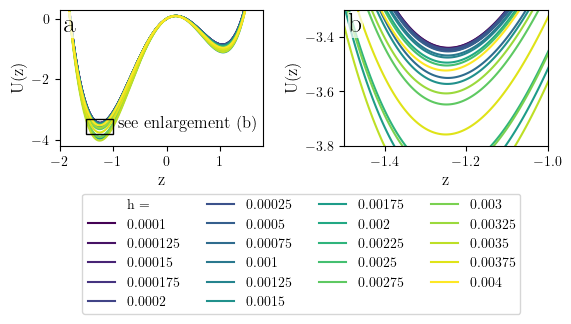

In [12]:
fig, ax = plt.subplots(2, 2, figsize=set_size(width, fraction=1, subplots=(2, 2)))

num_colors = 21
viridis_cmap = plt.cm.viridis
color_values = np.linspace(0, 1, num_colors)
colors_rgb = viridis_cmap(color_values)

for i in range(2):
    ax[0][i].plot(-1.2, -3.7, alpha = 0, label = "h =")
    ax[0][i].plot(xx, plot_potential(xx, aa), c = colors_rgb[0], label = str(0.0001))
    ax[0][i].plot(xx, plot_potential(xx, bb), c = colors_rgb[1], label = str(0.000125))
    ax[0][i].plot(xx, plot_potential(xx, cc), c = colors_rgb[2], label = str(0.00015))
    ax[0][i].plot(xx, plot_potential(xx, dd), c = colors_rgb[3], label = str(0.000175))

    ax[0][i].plot(xx, plot_potential(xx, ee), c = colors_rgb[4], label = str(0.0002))
    ax[0][i].plot(xx, plot_potential(xx, a), c = colors_rgb[5], label = str(0.00025))
    ax[0][i].plot(xx, plot_potential(xx, b), c = colors_rgb[6], label = str(0.0005))
    ax[0][i].plot(xx, plot_potential(xx, c), c = colors_rgb[7], label = str(0.00075))
    ax[0][i].plot(xx, plot_potential(xx, d), c = colors_rgb[8], label = str(0.001))
    ax[0][i].plot(xx, plot_potential(xx, e), c = colors_rgb[9], label = str(0.00125))
    ax[0][i].plot(xx, plot_potential(xx, f), c = colors_rgb[10], label = str(0.0015))
    ax[0][i].plot(xx, plot_potential(xx, g), c = colors_rgb[11], label = str(0.00175))
    #ax[0][i].plot(xx, plot_potential(xx, t), label = "TRUE", color = "k",)

    ax[0][i].plot(xx, plot_potential(xx, h), c = colors_rgb[12], label = str(0.002))
    ax[0][i].plot(xx, plot_potential(xx, ii), c = colors_rgb[13], label = str(0.00225))
    ax[0][i].plot(xx, plot_potential(xx, j), c = colors_rgb[14], label = str(0.0025))
    ax[0][i].plot(xx, plot_potential(xx, k), c = colors_rgb[15], label = str(0.00275))

    ax[0][i].plot(xx, plot_potential(xx, l), c = colors_rgb[16], label = str(0.003))
    ax[0][i].plot(xx, plot_potential(xx, m),  c = colors_rgb[17], label = str(0.00325))
    ax[0][i].plot(xx, plot_potential(xx, n), c = colors_rgb[18], label = str(0.0035))
    ax[0][i].plot(xx, plot_potential(xx, o), c = colors_rgb[19], label = str(0.00375))

    ax[0][i].plot(xx, plot_potential(xx, p),  c = colors_rgb[20], label = str(0.004))
    
rect = patches.Rectangle((-1.5, -3.8), 0.5, 0.5, linewidth=1, edgecolor='k', facecolor='none')
rect.set_zorder(10)
ax[0][0].add_patch(rect)
ax[0][0].text(-0.9,-3.6,"see enlargement (b)")

#total
ax[0][0].set_ylim(-4.2,0.3)
ax[0][0].set_xlim(-2,1.8)
#zoom
ax[0][1].set_ylim(-3.8,-3.3)
ax[0][1].set_xlim(-1.5,-1)

ax[1][1].tick_params(left=False, right=False, top=False, labelleft=False, labelright=False,
                bottom=False, labelbottom=False)
ax[1][0].tick_params(left=False, right=False, top=False, labelleft=False, labelright=False,
                bottom=False, labelbottom=False)

for spine in ['top', 'right', 'bottom', 'left']:
    ax[1][1].spines[spine].set_visible(False)
    ax[1][0].spines[spine].set_visible(False)
    
ax[1][1].set_facecolor('none')
ax[1][0].set_facecolor('none')

ax[0][0].legend(bbox_to_anchor=(2.3,-0.3), ncol=4)

ax[0][0].set_xlabel('z')
ax[0][1].set_xlabel('z')
ax[0][0].set_ylabel('U(z)')
ax[0][1].set_ylabel('U(z)')

plt.subplots_adjust(wspace=0.4)

abstand_prozent = 0.02
ax_text = ['a', 'b', 'c', 'd']
for i, ax in enumerate((ax[0][0], ax[0][1])):
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    x_abstand = (xlim[1] - xlim[0]) * abstand_prozent
    y_abstand = (ylim[1] - ylim[0]) * abstand_prozent
    ax.text(xlim[0] + x_abstand, ylim[1] - y_abstand, ax_text[i], va='top', ha='left', size = 20, bbox=dict(facecolor='white', alpha=0.7, edgecolor = 'none', pad = 0.5))

fig.savefig('C:/Users/morit/Documents/Masterarbeit/output_M/influence_of_h.jpg', format='jpg', dpi=600, bbox_inches='tight')

plt.show()

### Demonstration on Test Data

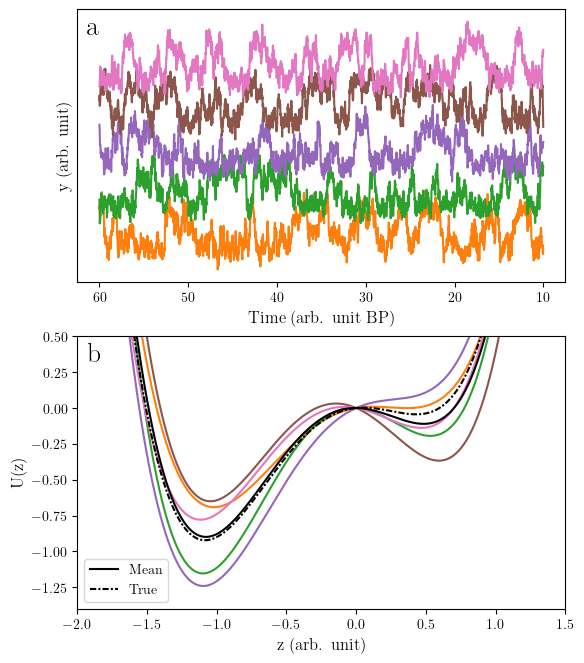

In [13]:
fig, ax = plt.subplots(2, 1, figsize=set_size(width, fraction=1, subplots=(2, 1)))

dT = 0.02
h = 0.001
L = int(dT/h)
t = np.arange(-60, -10, dT)
n = len(t) 

t = [abs(i) for i in t]

z = 0.7
a = [0.1, -1,  0.8, 1, 0.1, 1.5]

p = a        

ys=[]
for i in range(1,6):
    y = [0] * n  
    random.seed(i)                     
    y[0] = z + random.gauss(0, p[4])    
    for k in range(1, n):
        for l in range(int(L)):
            z = z - h*(4 * p[3]*z**3 + 3*p[2]*z**2 + 2*p[1]*z + p[0]) + random.gauss(0, p[5] * np.sqrt(h))
        y[k] = z + random.gauss(0, p[4]) 
    ys.append(y)

a = [ 0.15959223, -0.78223286,  0.61296548,  0.86430623,  0.09940876,  1.50712985]
b = [-0.06641269, -1.45179986,  0.99800761,  1.26940388,  0.09682199,  1.53835581]
c = [ 0.43412211, -1.06056363,  0.74485601,  1.03235998,  0.10179836,  1.52973278]
d = [-0.42092591, -1.30356858,  0.93750134,  1.17687086,  0.09543678,  1.50767107]
e = [-0.17834737, -0.93611263,  0.99106267,  1.00930485,  0.10310274,  1.47985838]

ax[0].plot(t,ys[0], c = colors['col1'])
ax[0].plot(t,[i+2 for i in ys[1]], c = colors['col2'])
ax[0].plot(t,[i+4 for i in ys[2]], c = colors['col3'])
ax[0].plot(t,[i+6 for i in ys[3]], c = colors['col4'])
ax[0].plot(t,[i+8 for i in ys[4]], c = colors['col5'])
ax[0].tick_params(left=False, labelleft=False)
ax[0].set_xlabel('Time (arb. unit BP)')
ax[0].set_ylabel('y (arb. unit)')

ax[1].plot(xx, plot_potential(xx, a), c = colors['col1'])
ax[1].plot(xx, plot_potential(xx, b), c = colors['col2'])
ax[1].plot(xx, plot_potential(xx, c), c = colors['col3'])
ax[1].plot(xx, plot_potential(xx, d), c = colors['col4'])
ax[1].plot(xx, plot_potential(xx, e), c = colors['col5'])
ax[1].plot(xx, plot_potential(xx, [(a + b + c + d + e) / 5 for a, b, c, d, e in zip(a,b,c,d,e)]), c = "k", label = "Mean")
ax[1].plot(xx, plot_potential(xx, [0.1, -1,  0.8, 1, 0.1, 1.5]), linestyle = lines['l2'], c = "k", label = "True")

ax[1].set_xlim(-2,1.5)
ax[1].set_ylim(-1.4,0.5)
ax[1].set_xlabel('z (arb. unit)')
ax[1].set_ylabel('U(z)')

ax[0].invert_xaxis()

abstand_prozent = 0.02
ax_text = ['a', 'b', 'c', 'd']
for i, ax in enumerate((ax[0], ax[1])):
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    x_abstand = (xlim[1] - xlim[0]) * abstand_prozent
    y_abstand = (ylim[1] - ylim[0]) * abstand_prozent
    ax.text(xlim[0] + x_abstand, ylim[1] - y_abstand, ax_text[i], va='top', ha='left', size = 20, bbox=dict(facecolor='white', alpha=0.7, edgecolor = 'none', pad = 0.5))

plt.legend()

fig.savefig('C:/Users/morit/Documents/Masterarbeit/output_M/five_timeseries.jpg', format='jpg', dpi=600, bbox_inches='tight')

plt.show()
t = [-i for i in t]

To find optimal values for band pass filter, the cost function between true forcing and band pass forcing is minimized

In [14]:
t = np.arange(-108.3, -10.4, dT)
t_ = [x for x in t]

df = pd.read_table(path+"insolation_mean_mon_7_65N_100k.txt", sep = "     ", header = None, engine = "python")
df.columns = ["Time", "Insolation"]
df["Time"] = df["Time"]-0.05# + 2.000
max_val, min_val = np.round(np.max(df["Time"]),3), np.round(np.min(df["Time"]),3)
max_difference = np.round(df['Time'][df["Time"]>t_[0]].diff().abs().max(),3)
soln = interp1d(df["Time"], df["Insolation"], kind="linear")(t_)
soln_ = soln
soln = (soln - np.mean(soln)) / np.std(soln)


In [15]:
dT = 0.02
h = 0.001
L = int(dT/h)
t = np.arange(-97.9, 0, dT) 
n = len(t) 
t_ = [x for x in t]

z = 0.7
a = [0.1, -1,  0.8, 1, 0.1, 1.5]

p = a   

forcing = 0.6 * soln

ys=[]
for i in range(4,5):
    y = [0] * n  
    random.seed(i)                     
    y[0] = z + random.gauss(0, p[4])    
    for k in range(1, n):
        for l in range(int(L)):
            z = z - h*(4 * p[3]*z**3 + 3*p[2]*z**2 + 2*p[1]*z + p[0]) + random.gauss(0, p[5] * np.sqrt(h))
        y[k] = z + random.gauss(0, p[4])
    y += forcing 
    ys.append(y)

series_forced = ys[0]
bandpass_cut = int(1/dT)
band_pass_optimized = return_band_pass([0.18335957, 0.44031794],1)

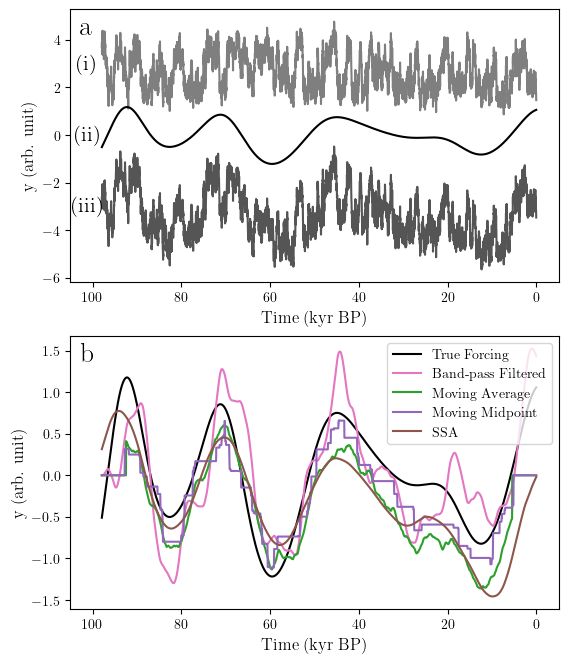

In [16]:
fig, ax = plt.subplots(2, 1, figsize=set_size(width, fraction=1, subplots=(2, 1)))

t = [abs(i) for i in t]

ax[0].plot(t, y-3, c = colors['forced'])
ax[0].plot(t, y-forcing+3, c = colors['raw'])
ax[0].plot(t, forcing, c = "k")

window_size=546
moveavg = moving_average(y, window_size)
moveavg = np.pad(moveavg, (int(window_size/2), int(window_size/2-1)), mode='constant', constant_values=0)

window_size=516
movemid = moving_midpoint(y, window_size)
movemid = np.pad(movemid, (int(window_size/2), int(window_size/2-1)), mode='constant', constant_values=0)

ax[1].plot(t, forcing, c="k", label = "True Forcing")
#band_pass_optimized = return_band_pass([0.18335957, 0.44031794],1)
#ax[1].plot(t, band_pass_optimized, label = "high-pass filtered 1")
band_pass_optimized = return_band_pass([0.06808234, 0.66038644] ,2)
ax[1].plot(t, band_pass_optimized, label = "Band-pass Filtered", c = colors['high'])
ax[1].plot(t, moveavg,  label = "Moving Average", c = colors['avg'])
ax[1].plot(t, movemid, label = "Moving Midpoint", c = colors['mid'])
ax[1].plot(t, pd.read_csv('y_SSA1und2.csv'), label = "SSA", c = colors['ssa'])

ax[0].text(101, 3, "(i)", va='center', ha='center', size = 15)
ax[0].text(101, 0, "(ii)", va='center', ha='center',size = 15)
ax[0].text(101, -3, "(iii)", va='center', ha='center',size = 15)

ax[1].legend()
ax[0].set_xlabel("Time (kyr BP)")
ax[0].set_ylabel('y (arb. unit)')
ax[1].set_xlabel("Time (kyr BP)")
ax[1].set_ylabel('y (arb. unit)')

ax[0].set_xlim(-5, 105)
ax[1].set_xlim(-5, 105)

ax[0].invert_xaxis()
ax[1].invert_xaxis()

abstand_prozent = 0.02
ax_text = ['a', 'b', 'c', 'd']
for i, ax in enumerate((ax[0], ax[1])):
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    x_abstand = (xlim[1] - xlim[0]) * abstand_prozent
    y_abstand = (ylim[1] - ylim[0]) * abstand_prozent
    ax.text(xlim[0] + x_abstand, ylim[1] - y_abstand, ax_text[i], va='top', ha='left', size = 20, bbox=dict(facecolor='white', alpha=0.7, edgecolor = 'none', pad = 0.5))

    
fig.savefig('C:/Users/morit/Documents/Masterarbeit/output_M/simu_forcing.jpg', format='jpg', dpi=600, bbox_inches='tight')

plt.show()
t = [-i for i in t]

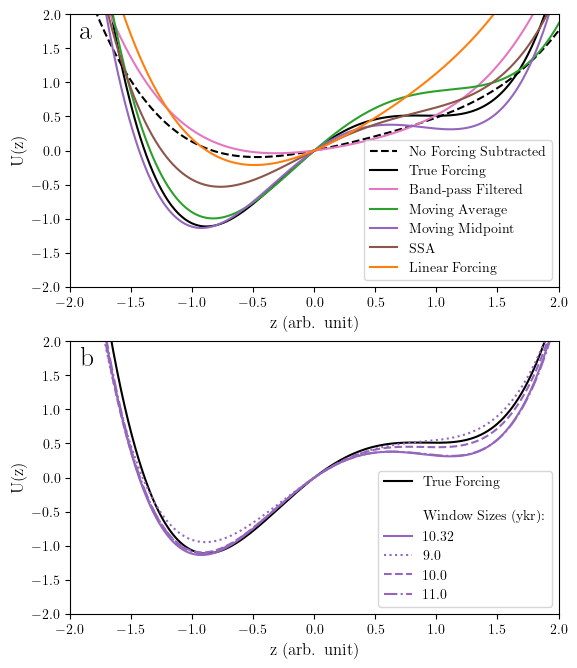

In [17]:
fig, ax = plt.subplots(2, 1, figsize=set_size(width, fraction=1, subplots=(2, 1)))

unprocessed = [0.34839285602108383, 0.20559346175980608, -0.16953981775168964, 0.09967209777513668, 0.09562651764625729, 1.4424464108793396]
forced_true = [1.385129621695381, -0.7596936412695897, -0.5942996128638451, 0.47973659147216013, 0.1175126806663449, 1.9680650954053391, 414.41882100565226, 840.8376420113045, 873.6418684128099]
moving_mid = [1.243690659447884, -0.8809765755516764, -0.5232497196750665, 0.482134068022542, 0.11731741820157619, 1.9753857173705645, 417.14061808792076, 846.2812361758415, 879.0854625773469]
moving_mid_hess = [0.5187767080940794, 0.40507854532724014, 0.13000319938394503, 0.093807594517997, 0.00836447647621075, 0.0839250630388941]
moving_avg = [1.5540143149262198, -0.36252221016946695, -0.6637830821585164, 0.34448241932485907, 0.12593592596972153, 2.0869077404978977, 524.1403441766361, 1060.2806883532721, 1093.0849147547774]
high_pass_1 = [0.4872876490203363, 0.1155158891753272, -0.25856515647150347, 0.19349404214130284, 0.11578366771747355, 1.8068977903554067, 329.574646347362, 671.149292694724, 703.9535190962293]
high_pass_2 = [0.22888527821133234, 0.2757007715383045, -0.11785682774427426, 0.13444784796641826, 0.10835826496037809, 1.694686488133071, 224.97887169316414, 461.9577433863283, 494.76196978783366]
forced = [0.7670126399022206, 0.5051655526374117, -0.28328634419708654, 0.14614863820416854, 0.09248572577072527, 1.4704539074466658, -1.5278440678059562, -33.36370687087765, -52.7274137417553, -14.455816273332381]
forced_hess = [0.3967847482640773, 0.2585957781789357, 0.08886276631972573, 0.05137941235705928, 0.008283237375992765, 0.05389839218699641, 0.6343748085246192]
moving_mid_500 = [1.2748775225735658, -0.7615055334524302, -0.5130921956155973, 0.44516935594869617, 0.11621000889877127, 1.9810856684252554, 420.0802062762025, 852.160412552405, 884.9646389539104]
moving_mid_450 = [1.1986580282796493, -0.5705786998597965, -0.46570525614779157, 0.3871476410544364, 0.11692193789425401, 1.9543314185306744, 410.88911597145216, 833.7782319429043, 866.5824583444097]
moving_mid_550 = [1.2374614451771935, -0.8582531288196446, -0.5273961819425002, 0.4763019571340921, 0.11621080213642468, 1.9721911143667616, 412.00752673733473, 836.0150534746695, 868.8192798761748]
SSA1und2 = [0.913544418187751, -0.1626034259857414, -0.38250900132136406, 0.26466440337212904, 0.11868714041609923, 1.9078549229710728, 398.30690174584765, 808.6138034916953, 841.4180298932007]

ax[0].plot(xx, plot_potential(xx, unprocessed), linestyle = "dashed", c="k", label = "No Forcing Subtracted")

var = forced_true
ax[0].plot(xx, plot_potential(xx, var),  c="k", label = "True Forcing")
var = high_pass_2
ax[0].plot(xx, plot_potential(xx, var),  label = "Band-pass Filtered", c = colors['high'])
var = moving_avg
ax[0].plot(xx, plot_potential(xx, var),  label = "Moving Average", c = colors['avg'])
var = moving_mid
ax[0].plot(xx, plot_potential(xx, var),  label = "Moving Midpoint", c = colors['mid'])
var = SSA1und2
ax[0].plot(xx, plot_potential(xx, var),  label = "SSA", c = colors['ssa'])
var = forced
ax[0].plot(xx, plot_potential(xx, var),  label = "Linear Forcing", c = colors['mitsui'])

ax[0].set_ylim(-2,2)
ax[0].set_xlim(-2,2)
ax[0].legend()

var = forced_true
ax[1].plot(xx, plot_potential(xx, var),  c="k", label = "True Forcing")
var = moving_mid
ax[1].scatter(0, 0, alpha = 0, label = "\n" + r"Window Sizes (ykr): ")
ax[1].plot(xx, plot_potential(xx, var),  label = str(516*dT), c = colors['mid'])
var = moving_mid_450
ax[1].plot(xx, plot_potential(xx, var),  label = str(450*dT), linestyle = "dotted", c = colors['mid'])
var = moving_mid_500
ax[1].plot(xx, plot_potential(xx, var),  label = str(500*dT), linestyle = "dashed", c = colors['mid'])
var = moving_mid_550
ax[1].plot(xx, plot_potential(xx, var),  label = str(550*dT), linestyle = "dashdot", c = colors['mid'])

ax[0].set_xlabel('z (arb. unit)')
ax[0].set_ylabel('U(z)')
ax[1].set_xlabel('z (arb. unit)')
ax[1].set_ylabel('U(z)')

ax[1].set_ylim(-2,2)
ax[1].set_xlim(-2,2)
ax[1].legend()

abstand_prozent = 0.02
ax_text = ['a', 'b', 'c', 'd']
for i, ax in enumerate((ax[0], ax[1])):
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    x_abstand = (xlim[1] - xlim[0]) * abstand_prozent
    y_abstand = (ylim[1] - ylim[0]) * abstand_prozent
    ax.text(xlim[0] + x_abstand, ylim[1] - y_abstand, ax_text[i], va='top', ha='left', size = 20, bbox=dict(facecolor='white', alpha=0.7, edgecolor = 'none', pad = 0.5))


fig.savefig('C:/Users/morit/Documents/Masterarbeit/output_M/remove_forcing.jpg', format='jpg', dpi=600, bbox_inches='tight')

plt.show()

In [18]:
'''
fun = -moving_mid_450[6]

print(fun)
k = 7
data = data_cut(cal_, -60, -25)[1]

aic = 2*(k - fun)
bic = -2*fun + k*np.log(len(data)-50)

print(aic, bic)
#print(moving_mid[7:])

'''

'\nfun = -moving_mid_450[6]\n\nprint(fun)\nk = 7\ndata = data_cut(cal_, -60, -25)[1]\n\naic = 2*(k - fun)\nbic = -2*fun + k*np.log(len(data)-50)\n\nprint(aic, bic)\n#print(moving_mid[7:])\n\n'

In this version of the PCA_ function, after computing the principal components, it checks whether the sign of the principal component matches the correlation between the principal component and data1. If the correlation is negative, the sign of the principal component is reversed. Otherwise, it remains unchanged. This should automatically adjust the sign of the principal component according to the expected trends in the data.

C:\Users\morit\AppData\Local\Temp\ipykernel_10520\3684436963.py:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(2,3,1)


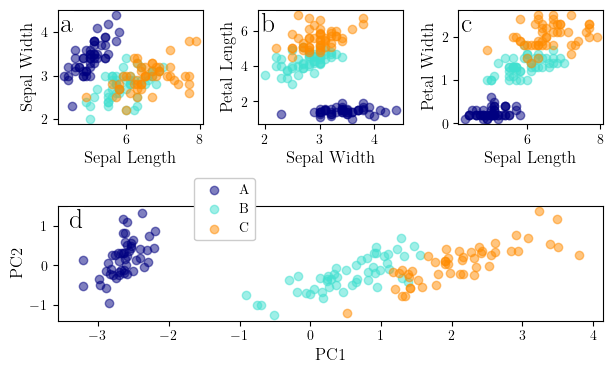

In [19]:
fig, ax = plt.subplots(1, 1, figsize=set_size(width, fraction=1, subplots=(1, 1)))
ax1 = plt.subplot(2,3,1)
ax2 = plt.subplot(2,3,2)
ax3 = plt.subplot(2,3,3)
ax4 = plt.subplot(2,1,2)
axes = [ax1, ax2, ax3, ax4]

iris = datasets.load_iris()
X = iris.data
y = iris.target
target_names = ['A', 'B', 'C']

pca = PCA(n_components=2)
X_r = pca.fit_transform(X)

# Subplot 1: Merkmal 0 vs. Merkmal 1
for color, i, target_name in zip(['navy', 'turquoise', 'darkorange'], [0, 1, 2], ['A', 'B', 'C']):
    ax1.scatter(X[y == i, 0], X[y == i, 1], color=color, alpha=.5, label=target_name)
ax1.set_xlabel('Sepal Length')
ax1.set_ylabel('Sepal Width')

# Subplot 1: Merkmal 0 vs. Merkmal 1
for color, i, target_name in zip(['navy', 'turquoise', 'darkorange'], [0, 1, 2], ['A', 'B', 'C']):
    ax2.scatter(X[y == i, 1], X[y == i, 2], color=color, alpha=.5, label=target_name)
ax2.set_xlabel('Sepal Width')
ax2.set_ylabel('Petal Length')

# Subplot 1: Merkmal 0 vs. Merkmal 1
for color, i, target_name in zip(['navy', 'turquoise', 'darkorange'], [0, 1, 2], ['A', 'B', 'C']):
    ax3.scatter(X[y == i, 0], X[y == i, 3], color=color, alpha=.5, label=target_name)
ax3.set_xlabel('Sepal Length')
ax3.set_ylabel('Petal Width')

# Subplot 4: PCA 1 vs. PCA 2
for color, i, target_name in zip(['navy', 'turquoise', 'darkorange'], [0, 1, 2], ['A', 'B', 'C']):
     ax4.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.5, label=target_name)
ax4.set_xlabel('PC1')
ax4.set_ylabel('PC2')

leg = ax4.legend(loc = (0.25, 0.7))

leg.get_frame().set_alpha(1)

abstand_prozent = 0.02
ax_text = ['a', 'b', 'c', 'd']
for i, ax in enumerate((ax1, ax2, ax3, ax4)):
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    x_abstand = (xlim[1] - xlim[0]) * abstand_prozent
    y_abstand = (ylim[1] - ylim[0]) * abstand_prozent
    ax.text(xlim[0] + x_abstand, ylim[1] - y_abstand, ax_text[i], va='top', ha='left', size = 20, bbox=dict(facecolor='white', alpha=0.7, edgecolor = 'none', pad = 0.5))

plt.tight_layout()

fig.savefig('C:/Users/morit/Documents/Masterarbeit/output_M/Appendix_PCA.jpg', format='jpg', dpi=600, bbox_inches='tight')

plt.show()

In [20]:
(pca.explained_variance_ratio_[0]+pca.explained_variance_ratio_[1])*100
100-97.76

2.239999999999995

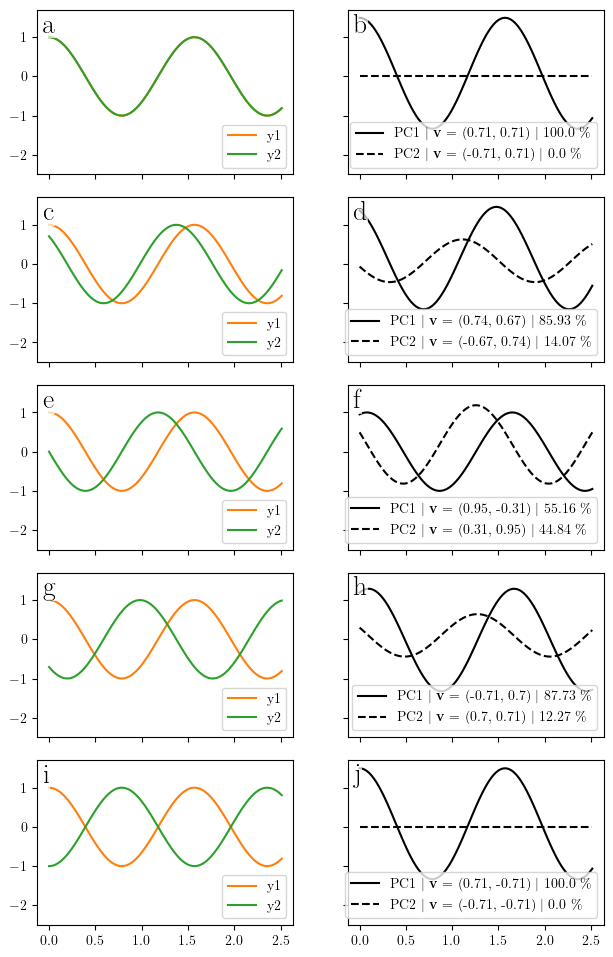

In [21]:
fig, ax = plt.subplots(5, 2, figsize=set_size(width, fraction=1, subplots=(5, 2)), sharex = True, sharey = True)

def PCA_(data1, data2, comp, i):
    combined_data = np.vstack((data1, data2)).T
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(combined_data)
    
    if i == 1:
        # Überprüfen, ob das Vorzeichen der Hauptkomponente geändert werden muss
        if np.corrcoef(pca_result[:, comp], data1)[0, 1] < 0:
            return [-pca_result[:, comp], pca.components_, pca.explained_variance_ratio_]
        else:
            return [pca_result[:, comp], pca.components_, pca.explained_variance_ratio_]
    else:
        return [pca_result[:, comp], pca.components_, pca.explained_variance_ratio_]
    
    
def PCA_(data1, data2, comp, ref_direction=None):
    combined_data = np.vstack((data1, data2)).T
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(combined_data)
    
    # Check if reference direction is provided and flip PCs if needed
    if ref_direction is not None:
        if pca.components_[0][0] * ref_direction[0][0] < 0:
            pca_result[:, 0] *= -1
            #pca.components_ *= -1

        if pca.components_[1][1] * ref_direction[1][1] < 0:
            pca_result[:, 1] *= -1
            #pca.components_ *= -1
   
    return [pca_result[:, comp], np.round(pca.components_,2), np.round(pca.explained_variance_ratio_*100,2)]

def function(p=4):
    return np.cos(p*t+offset)
    
t = np.linspace(0, 2*np.pi/5*2, 100)
offset = 0

ref_direction = PCA_(function(4), function(4), None, None)[1]

data1 = function()
data2 = function()

ax[0, 0].plot(t, data1, colors['col1'], label="y1")
ax[0, 0].plot(t, data2, colors['col2'], label="y2")

var = [PCA_(data1, data2, 0, ref_direction)[0], PCA_(data1, data2, 0, ref_direction)[1][0], PCA_(data1, data2, 0, ref_direction)[2][0]]
ax[0, 1].plot(t, var[0],  "k", label = r'PC1 $| $ $\textbf{v}$ = (' + str(var[1][0]) + ', ' + str(var[1][1]) + ') $|$ ' + str(var[2]) + r' $\%$') 
var = [PCA_(data1, data2, 1, ref_direction)[0], PCA_(data1, data2, 1, ref_direction)[1][1], PCA_(data1, data2, 1, ref_direction)[2][1]]
ax[0, 1].plot(t, var[0],  "k--", label = r'PC2 $| $ $\textbf{v}$ = (' + str(var[1][0]) + ', ' + str(var[1][1]) + ') $|$ ' + str(var[2]) + r' $\%$') 


offset = 0
data1 = function()
offset = np.pi/4
data2 = function()

ax[1, 0].plot(t, data1, colors['col1'], label="y1")
ax[1, 0].plot(t, data2, colors['col2'], label="y2")

var = [PCA_(data1, data2, 0, ref_direction)[0], PCA_(data1, data2, 0, ref_direction)[1][0], PCA_(data1, data2, 0, ref_direction)[2][0]]
ax[1, 1].plot(t, var[0],  "k", label = r'PC1 $| $ $\textbf{v}$ = (' + str(var[1][0]) + ', ' + str(var[1][1]) + ') $|$ ' + str(var[2]) + r' $\%$') 
var = [PCA_(data1, data2, 1, ref_direction)[0], PCA_(data1, data2, 1, ref_direction)[1][1], PCA_(data1, data2, 1, ref_direction)[2][1]]
ax[1, 1].plot(t, var[0],  "k--", label = r'PC2 $| $ $\textbf{v}$ = (' + str(var[1][0]) + ', ' + str(var[1][1]) + ') $|$ ' + str(var[2]) + r' $\%$') 



offset = 0
data1 = function()
offset = 2*np.pi/4
data2 = function()

ax[2, 0].plot(t, data1, colors['col1'], label="y1")
ax[2, 0].plot(t, data2, colors['col2'], label="y2")

var = [PCA_(data1, data2, 0, ref_direction)[0], PCA_(data1, data2, 0, ref_direction)[1][0], PCA_(data1, data2, 0, ref_direction)[2][0]]
ax[2, 1].plot(t, var[0],  "k", label = r'PC1 $| $ $\textbf{v}$ = (' + str(var[1][0]) + ', ' + str(var[1][1]) + ') $|$ ' + str(var[2]) + r' $\%$') 
var = [PCA_(data1, data2, 1, ref_direction)[0], PCA_(data1, data2, 1, ref_direction)[1][1], PCA_(data1, data2, 1, ref_direction)[2][1]]
ax[2, 1].plot(t, var[0],  "k--", label = r'PC2 $| $ $\textbf{v}$ = (' + str(var[1][0]) + ', ' + str(var[1][1]) + ') $|$ ' + str(var[2]) + r' $\%$') 


offset = 0
data1 = function()
offset = 3*np.pi/4
data2 = function()

ax[3, 0].plot(t, data1, colors['col1'], label="y1")
ax[3, 0].plot(t, data2, colors['col2'], label="y2")

var = [PCA_(data1, data2, 0, ref_direction)[0], PCA_(data1, data2, 0, ref_direction)[1][0], PCA_(data1, data2, 0, ref_direction)[2][0]]
ax[3, 1].plot(t, var[0],  "k", label = r'PC1 $| $ $\textbf{v}$ = (' + str(var[1][0]) + ', ' + str(var[1][1]) + ') $|$ ' + str(var[2]) + r' $\%$') 
var = [PCA_(data1, data2, 1, ref_direction)[0], PCA_(data1, data2, 1, ref_direction)[1][1], PCA_(data1, data2, 1, ref_direction)[2][1]]
ax[3, 1].plot(t, var[0],  "k--", label = r'PC2 $| $ $\textbf{v}$ = (' + str(var[1][0]) + ', ' + str(var[1][1]) + ') $|$ ' + str(var[2]) + r' $\%$') 


offset = 0
data1 = function()
offset = np.pi
data2 = function()

ax[4, 0].plot(t, data1, colors['col1'], label="y1")
ax[4, 0].plot(t, data2, colors['col2'], label="y2")

var = [PCA_(data1, data2, 0, ref_direction)[0], PCA_(data1, data2, 0, ref_direction)[1][0], PCA_(data1, data2, 0, ref_direction)[2][0]]
ax[4, 1].plot(t, var[0],  "k", label = r'PC1 $| $ $\textbf{v}$ = (' + str(var[1][0]) + ', ' + str(var[1][1]) + ') $|$ ' + str(var[2]) + r' $\%$') 
var = [PCA_(data1, data2, 1, ref_direction)[0], PCA_(data1, data2, 1, ref_direction)[1][1], PCA_(data1, data2, 1, ref_direction)[2][1]]
ax[4, 1].plot(t, var[0],  "k--", label = r'PC2 $| $ $\textbf{v}$ = (' + str(var[1][0]) + ', ' + str(var[1][1]) + ') $|$ ' + str(var[2]) + r' $\%$') 


abstand_prozent = 0.02
ax_text = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']
for i, ax in enumerate((ax[0,0], ax[0,1], ax[1, 0], ax[1,1], ax[2,0], ax[2,1], ax[3, 0], ax[3,1], ax[4,0], ax[4, 1])):
    ax.set_ylim(-2.5,1.7)
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    x_abstand = (xlim[1] - xlim[0]) * abstand_prozent
    y_abstand = (ylim[1] - ylim[0]) * abstand_prozent
    ax.text(xlim[0] + x_abstand, ylim[1] - y_abstand, ax_text[i], va='top', ha='left', size = 20, bbox=dict(facecolor='white', alpha=0.7, edgecolor = 'none', pad = 0.5))
    ax.legend(loc=4)

plt.tight_layout()
fig.savefig('C:/Users/morit/Documents/Masterarbeit/output_M/PCA_sample.jpg', format='jpg', dpi=600, bbox_inches='tight')
plt.show()

# <ins>Real Data</ins>
All Data taken from -50 to -25 kyr. SSA applied to whole data (-120.28 to 1.91 kyr) before cutting. 
### Overview

NGRIP1:  oldest: -123.111 | newest: -0.081 | largest deltaT: 0.02
NGRIP2:  oldest: -123.111 | newest: -0.081 | largest deltaT: 0.02
CALCIUM: oldest: -123.111 | newest: -0.081 | largest deltaT: 0.02
WD:        oldest: -67.73 | newest: 0.056 | largest deltaT: 0.088
EDML:    oldest: -144.109 | newest: 0.088 | largest deltaT: 0.044


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


ANT_ST:   oldest: -139.83 | newest: -0.04 | largest deltaT: 0.01
BENTHIC:  oldest: -5320.0 | newest: -0.0 | largest deltaT: 1.0
INSO (N): oldest: -200.05 | newest: -0.05 | largest deltaT: 0.1
INSO (S):  oldest: -198.0 | newest: 2.0 | largest deltaT: 0.1


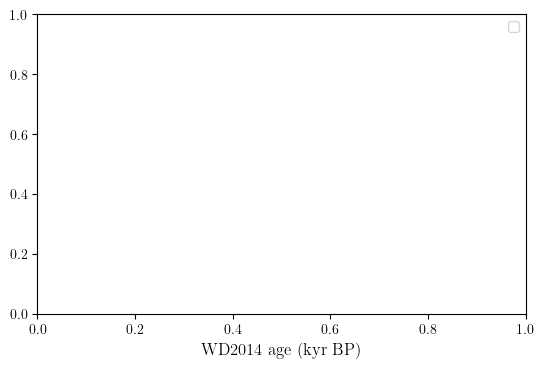

In [22]:
fig, ax = plt.subplots(1, 1, figsize=set_size(width, fraction=1, subplots=(1, 1)))

dT = 0.02
t = np.arange(-67.73, -10.4, dT)
t_ = [x for x in t]

# Import real data:
path = "C:/Users/morit/documents/Masterarbeit/data/"

### NGRIP d18O 20 year resolution ###
df = pd.read_csv(path + "NGRIP_d18O_GICC05modelext.txt", sep = "\t", header = 66, engine = "python")
df["Age (years b2k)"] = -df["Age (years b2k)"]/1000 # convert to kyr
df["Age (years b2k)"] = df["Age (years b2k)"]-0.05 # convert b2k to BP
df["Age (years b2k)"] = df["Age (years b2k)"]-0.01 # datapoint reflects midpoint of interval
df["Age (years b2k)"] = df["Age (years b2k)"]*1.0063 # For consistency with WD2014 chronology and Hulu cave 
max_val, min_val = np.round(np.max(df["Age (years b2k)"]),3), np.round(np.min(df["Age (years b2k)"]),3)
max_difference = np.round(df['Age (years b2k)'][df['Age (years b2k)']>t_[0]].diff().abs().max(),3)
print("NGRIP1:  oldest: " + str(min_val) + " | " + "newest: " + str(max_val) + " | " + "largest deltaT: " + str(max_difference))
ngrip = interp1d(df["Age (years b2k)"], df["NGRIP d18O (permil)"], kind="linear")(t_)
ngrip_=ngrip
ngrip = (ngrip - np.mean(ngrip)) / np.std(ngrip)
#plt.plot(t,ngrip, label = r"ngrip1 d18O")


### NGRIP d18O 20 year resolution version 2 ###
df = pd.read_csv(path + "ngrip_20yr.txt", sep = "\t", header = 50, engine = "python")
df_ = pd.DataFrame(df['Age'])
df_['d18O'] = df['d18O NGRIP1'].combine_first(df['d18O NGRIP2'])
df_['d18O'] = df_['d18O'].str.replace(',', '.')
df_ = df_.drop(df_.index[0])
df_['Age']=pd.to_numeric(df_['Age'])
df_["Age"] = -df_["Age"]/1000 # convert to kyr
df_["Age"] = df_["Age"]-0.05 # convert b2k to BP
df_["Age"] = df_["Age"]-0.01
df_["Age"] = df_["Age"]*1.0063 # For consistency with WD2014 chronology and Hulu cave 
max_val, min_val = np.round(np.max(df_["Age"]),3), np.round(np.min(df_["Age"]),3)
max_difference = np.round(df_['Age'][df_['Age']>t_[0]].diff().abs().max(),3)
print("NGRIP2:  oldest: " + str(min_val) + " | " + "newest: " + str(max_val) + " | " + "largest deltaT: " + str(max_difference))
ngrip2 = interp1d(df_["Age"], df_["d18O"], kind="linear")(t_)
ngrip2_=ngrip2
ngrip2 = (ngrip2 - np.mean(ngrip2)) / np.std(ngrip2)
#plt.plot(t,ngrip2, label = r"ngrip2 d18O")


### NGRIP calcium 20 year resolution ###
df = pd.read_csv(path + "ngrip_20yr.txt", sep = "\t", header = 50, engine = "python")
df_ = pd.DataFrame(df['Age'])
df_['Ca2+'] = df['[Ca2+] NGRIP2']
df_['Ca2+'] = df_['Ca2+'].str.replace(',', '.')
df_ = df_.drop(df_.index[0])
df_['Age']=pd.to_numeric(df_['Age'])
df_["Age"] = -df_["Age"]/1000
df_["Age"] = df_["Age"]-0.05
df_["Age"] = df_["Age"]-0.01
df_["Age"] = df_["Age"]*1.0063
df_cleaned = df_.dropna(subset=['Ca2+']) 
max_val, min_val = np.round(np.max(df_["Age"]),3), np.round(np.min(df_["Age"]),3)
max_difference = np.round(df_['Age'][df_["Age"]>t_[0]].diff().abs().max(),3)
print("CALCIUM: oldest: " + str(min_val) + " | " + "newest: " + str(max_val) + " | " + "largest deltaT: " + str(max_difference))
cal = interp1d(df_cleaned['Age'].values, df_cleaned['Ca2+'].values, kind="linear")(t_)
cal = -np.log(cal)
cal_= cal
cal = (cal - np.mean(cal)) / np.std(cal)
#plt.plot(t,cal, label = r"ngrip calcium")


### WD d18O ###
WD_age = pd.read_csv(path + "WD2014_506modAKZ291b_v4.txt", sep = "\t", header = 12, engine = "python")
df = pd.read_csv(path + "WAIS_project_members_Source_Data.txt", sep = "\t", header = 44, engine = "python")
df1 = df[["Depths Top (m)", "Depths Bottom (m)"]].mean(axis=1).to_frame()
df1.rename(columns={0: "Depth"}, inplace=True)
df2 = df[["WD2014 Age Top (ka1950.0)", "WD2014 Age Bottom (ka1950.0)"]].mean(axis=1).to_frame()
df2.rename(columns={0: "WD2014 Age"}, inplace=True)
df3 = df["Isotope Data d18O (per mil)"]
df_ = pd.concat([df1, df2, df3], axis=1)
WD_age["Ice age (years BP)"] = -WD_age["Ice age (years BP)"]/1000
df_["WD2014 Age"] = interp1d(WD_age["Depth (m)"], WD_age["Ice age (years BP)"], kind='linear', fill_value='extrapolate')(df_["Depth"])
max_val, min_val = np.round(np.max(df_["WD2014 Age"]),3), np.round(np.min(df_["WD2014 Age"]),3)
max_difference = np.round(df_["WD2014 Age"][df_["WD2014 Age"]>t_[0]].diff().abs().max(),3)
print("WD:        oldest: " + str(min_val) + " | " + "newest: " + str(max_val) + " | " + "largest deltaT: " + str(max_difference))
wd = interp1d(df_["WD2014 Age"], df_["Isotope Data d18O (per mil)"], kind="linear")(t_)
wd_= wd
wd = (wd - np.mean(wd)) / np.std(wd)
#plt.plot(t,wd, label = r"WD")


### EDML d18O ###
df = pd.read_csv(path + "EDML.txt", sep = "\t", header = 22, engine = "python")
df["Age [ka BP]"] = -df["Age [ka BP]"]
max_val, min_val = np.round(np.max(df["Age [ka BP]"]),3), np.round(np.min(df["Age [ka BP]"]),3)
max_difference = np.round(df['Age [ka BP]'][df["Age [ka BP]"]>t_[0]].diff().abs().max(),3)
edml = interp1d(df["Age [ka BP]"], df["δ18O H2O [‰ SMOW]"], kind="linear")(t_)
edml_= edml
edml = (edml - np.mean(edml)) / np.std(edml)
print("EDML:    oldest: " + str(min_val) + " | " + "newest: " + str(max_val) + " | " + "largest deltaT: " + str(max_difference))
#plt.plot(t,edml, label = "EDML")

### WD-EDC-EDML d18O stack ###
df = pd.read_csv(path + "antarctica_stack.txt", sep = "\t", skipinitialspace=True, header = 26, engine = "python")
df["Age [ka BP]"] = -df["Age [ka BP]"]#+1.950
max_val, min_val = np.round(np.max(df["Age [ka BP]"]),3), np.round(np.min(df["Age [ka BP]"]),3)
max_difference = np.round(df['Age [ka BP]'][df["Age [ka BP]"]>t_[0]].diff().abs().max(),3)
print("ANT_ST:   oldest: " + str(min_val) + " | " + "newest: " + str(max_val) + " | " + "largest deltaT: " + str(max_difference))
ant_st = interp1d(df["Age [ka BP]"], df["δ18O H2O [‰ SMOW]"], kind="linear")(t_)
ant_st_= ant_st
ant_st = (ant_st - np.mean(ant_st)) / np.std(ant_st)
#plt.plot(t, ant_st, label = "WD-EDC-EDML")

### benthic ###
df = pd.read_csv(path  + "Global_stack_d18O.txt", sep = "\t", header = 57, engine = "python")
df["Age [ka BP]"] = -df["Age [ka BP]"]# + 1.950
max_val, min_val = np.round(np.max(df["Age [ka BP]"]),3), np.round(np.min(df["Age [ka BP]"]),3)
max_difference = np.round(df['Age [ka BP]'][df["Age [ka BP]"]>t_[0]].diff().abs().max(),3)
benthic = interp1d(df["Age [ka BP]"], df["δ18O stack [‰]"], kind="linear")(t_)
benthic_= benthic
benthic = (benthic - np.mean(benthic)) / np.std(benthic)
print("BENTHIC:  oldest: " + str(min_val) + " | " + "newest: " + str(max_val) + " | " + "largest deltaT: " + str(max_difference))
#plt.plot(t, -benthic, label = "benthic")

### insolation north ###
#http://vo.imcce.fr/insola/earth/online/earth/online/index.php
df = pd.read_table(path+"insolation_mean_mon_7_65N_100k.txt", sep = "     ", header = None, engine = "python")
df.columns = ["Time", "Insolation"]
df["Time"] = df["Time"]-0.05# + 2.000
max_val, min_val = np.round(np.max(df["Time"]),3), np.round(np.min(df["Time"]),3)
max_difference = np.round(df['Time'][df["Time"]>t_[0]].diff().abs().max(),3)
soln = interp1d(df["Time"], df["Insolation"], kind="linear")(t_)
soln_ = soln
soln = (soln - np.mean(soln)) / np.std(soln)
print("INSO (N): oldest: " + str(min_val) + " | " + "newest: " + str(max_val) + " | " + "largest deltaT: " + str(max_difference))
#plt.plot(t,soln, label = "sol (n)")

### insolation south ###
df = pd.read_table(path+"insolation_mean_mon_7_65S_100k.txt", sep = "     ", header = None, engine = "python")
df.columns = ["Time", "Insolation"]
df["Time"] = df["Time"] + 2.000
max_val, min_val = np.round(np.max(df["Time"]),3), np.round(np.min(df["Time"]),3)
max_difference = np.round(df['Time'][df["Time"]>t_[0]].diff().abs().max(),3)
sols = interp1d(df["Time"], df["Insolation"], kind="linear")(t_)
sols_ = sols
sols = (sols - np.mean(sols)) / np.std(sols)
print("INSO (S):  oldest: " + str(min_val) + " | " + "newest: " + str(max_val) + " | " + "largest deltaT: " + str(max_difference))
#plt.plot(t,sols, label = "sol (s)")

plt.legend()
plt.xlabel("WD2014 age (kyr BP)")
plt.show()

C:\Users\morit\AppData\Local\Temp\ipykernel_10520\2606862764.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  axs[0] = plt.subplot(121, projection=ccrs.NorthPolarStereo())


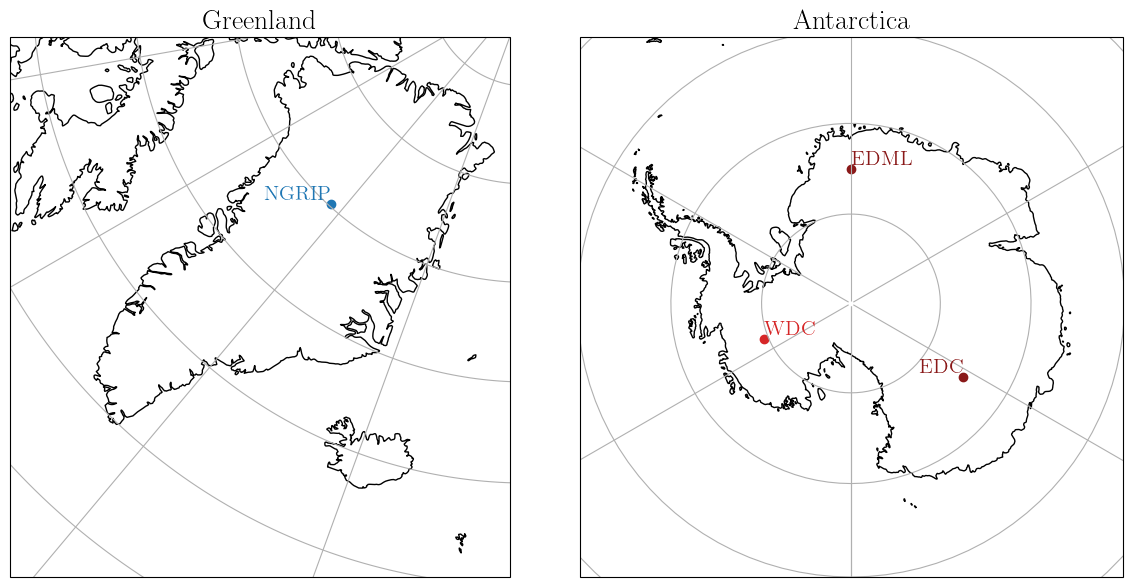

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': ccrs.SouthPolarStereo()})

fsize = 20

axs[0] = plt.subplot(121, projection=ccrs.NorthPolarStereo())
axs[0].set_extent([-60, -10, 60, 85], ccrs.PlateCarree())
axs[0].coastlines()
axs[0].gridlines()
axs[0].scatter(-42.32, 75.10, color=colors['ngrip'], marker='o', transform=ccrs.PlateCarree(), label='Stadt')
axs[0].text(-42.32, 75.10, "NGRIP", transform=ccrs.PlateCarree(), ha='right', va='bottom', color=colors['ngrip'], fontsize=fsize-5, weight='bold')
axs[0].set_title("Greenland", size = fsize)

# Erster Subplot (Südpolsterprojektion)
axs[1].set_extent([-180, 180, -90, -60], ccrs.PlateCarree())
axs[1].coastlines()
axs[1].gridlines()
axs[1].scatter(-112.086, -79.468, color=colors['wdc'], marker='o', transform=ccrs.PlateCarree(), label='Stadt')
axs[1].text(-112.086, -79.468, "WDC", transform=ccrs.PlateCarree(), ha='left', va='bottom', color=colors['wdc'], fontsize=fsize-5, weight='bold')
axs[1].scatter(123.350000 , -75.100000, color=colors['stack'], marker='o', transform=ccrs.PlateCarree(), label='Stadt')
axs[1].text(123.350000 , -75.100000, "EDC", transform=ccrs.PlateCarree(), ha='right', va='bottom', color=colors['stack'], fontsize=fsize-5, weight='bold')
axs[1].scatter(0.068400 , -75.002500, color=colors['stack'], marker='o', transform=ccrs.PlateCarree(), label='Stadt')
axs[1].text(0.068400 , -75.002500, "EDML", transform=ccrs.PlateCarree(), ha='left', va='bottom', color=colors['stack'], fontsize=fsize-5, weight='bold')
axs[1].set_title("Antarctica", size = fsize)
# Layout verbessern
plt.tight_layout()

fig.savefig('C:/Users/morit/Documents/Masterarbeit/output_M/core_location.jpg', format='jpg', dpi=600, bbox_inches='tight')


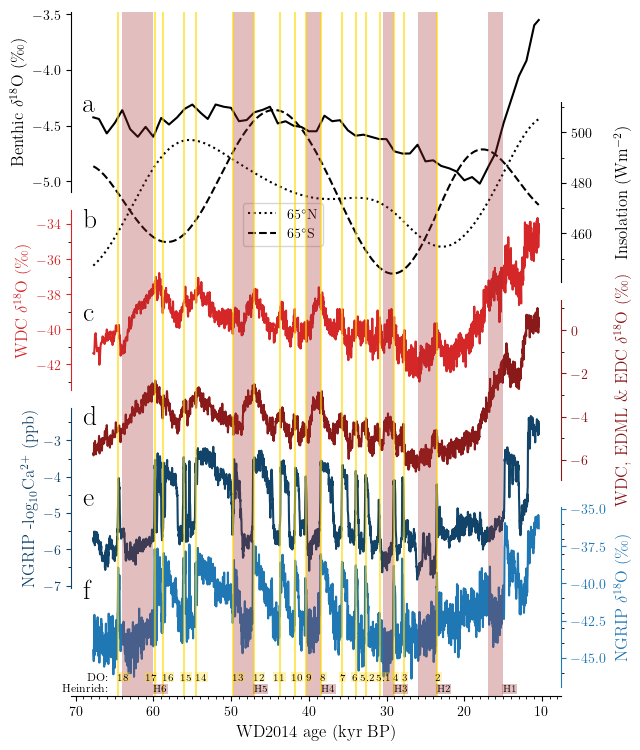

In [24]:
fig = plt.figure(figsize=(4.9,1.8))
#fig = plt.figure(figsize=set_size(width, fraction=1, subplots=(1, 1)))

label_dist = -403

color = colors['ngrip']
ax2 = fig.add_axes([0,0.05,1,1])
ax2.plot(t, ngrip_, c = color)
for spine in ['top', 'bottom', 'left']:
    ax2.spines[spine].set_visible(False) 
ax2.spines['right'].set_color(color)
ax2.tick_params(labelleft=False, labelbottom=False, labelright=True)
ax2.set_ylabel(r'NGRIP $\delta^{18}$O (‰)', labelpad=label_dist, c = color)
ax2.patch.set_alpha(0)
ax2.tick_params('x', length=0)
ax2.tick_params('y', colors=color)
ax2.yaxis.tick_right()

color = colors['cal']
ax3 = fig.add_axes([0,0.6,1,1])
ax3.plot(t,cal_, c=color)
for spine in ['top', 'right', 'bottom']:
    ax3.spines[spine].set_visible(False) 
ax3.spines["left"].set_color(color)
ax3.tick_params(labelleft=True, labelbottom=False, labelright=False)
ax3.patch.set_alpha(0)
ax3.set_ylabel(r'NGRIP -log$_{10}$Ca$^{2+}$ (ppb)', c = color)
ax3.tick_params('x', length=0)
ax3.tick_params('y', colors = color)

color = colors['stack']
ax4 = fig.add_axes([0,1.2,1,1])
ax4.plot(t, ant_st_, c = color)
for spine in ['top', 'bottom', 'left']:
    ax4.spines[spine].set_visible(False) 
ax4.spines['right'].set_color(color)
ax4.tick_params(labelleft=False, labelbottom=False, labelright=True)
ax4.set_ylabel(r'WDC, EDML $\&$ EDC $\delta^{18}$O (‰)', labelpad=label_dist, c = color)
ax4.patch.set_alpha(0)
ax4.tick_params('x', length=0)
ax4.tick_params('y', colors=color)
ax4.yaxis.tick_right()

color = colors['wdc']
ax5 = fig.add_axes([0,1.7,1,1])
ax5.plot(t,wd_, c=color)
for spine in ['top', 'right', 'bottom']:
    ax5.spines[spine].set_visible(False) 
ax5.spines["left"].set_color(color)
ax5.tick_params(labelleft=True, labelbottom=False, labelright=False)
ax5.patch.set_alpha(0)
ax5.set_ylabel('WDC $\delta^{18}$O (‰)', c = color)
ax5.tick_params('x', length=0)
ax5.tick_params('y', colors = color)

color = "k"
ax6 = fig.add_axes([0,2.3,1,1])
ax6.plot(t,soln_, linestyle = "dotted", c=color, label = r"65$^\circ$N")
ax6.plot(t,sols_, "--", c=color, label = r"65$^\circ$S")
for spine in ['top', 'bottom', 'left']:
    ax6.spines[spine].set_visible(False) 
ax6.spines['right'].set_color(color)
ax6.tick_params(labelleft=False, labelbottom=False, labelright=True)
ax6.set_ylabel(r'Insolation (Wm$^{-2}$)', labelpad=label_dist, c = color)
ax6.patch.set_alpha(0)
ax6.tick_params('x', length=0)
ax6.tick_params('y', colors=color)
ax6.yaxis.tick_right()

color = "k"
ax7 = fig.add_axes([0,2.8,1,1])
ax7.plot(t,-benthic_, c=color)
for spine in ['top', 'right', 'bottom']:
    ax7.spines[spine].set_visible(False) 
ax7.spines["left"].set_color(color)
ax7.tick_params(labelleft=True, labelbottom=False, labelright=False)
ax7.patch.set_alpha(0)
ax7.set_ylabel('Benthic $\delta^{18}$O (‰)', c = color)
ax7.tick_params('x', length=0)
ax7.tick_params('y', colors = color)

t = [abs(i) for i in t]

ax1 = fig.add_axes([0,0,1,3.8])
ax1.plot(t,ngrip,alpha=0)
for spine in ['top', 'right', 'left']:
    ax1.spines[spine].set_visible(False)   
ax1.tick_params(labelleft=False)
ax1.patch.set_alpha(0)
ax1.tick_params('y', length=0)
ax1.set_xlabel("WD2014 age (kyr BP)")

ax1.invert_xaxis()

dos = [23.5, 27.8, 29.05, 30.9, 32.7, 33.95, 35.7, 38.4, 40.4, 41.8, 43.7, 47.1, 49.7, 54.5, 56.1, 58.7, 59.8, 64.5]
dos = [-i for i in dos]
do_name = [ 2, 3, 4, 5.1, 5.2, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
do_posi = [ 0.2, 0.2, 0.1, 0.5, 0.7, 0.5, 0.3, 0.1, 0, 0.4, 0.8, 0, 0, 0, 0.4, 0.1, 1.2, 0]
do_posi = [-i for i in do_posi]
for i in range(len(dos)):
    ax1.axvline(x=-dos[i], c="gold", alpha = 0.6)
    ax1.text(-dos[i]-do_posi[i],-2.4,str(do_name[i]), size = 7, bbox=dict(facecolor='gold', alpha=0.3, edgecolor = 'none', pad = 0.5))
ax1.text(-dos[-1]+4,-2.4, "DO:", size = 8)

ax1.set_ylim(ax1.get_ylim())

hainrich_left = [15, 23.5, 29.05, 38.4, 47.1, 60]
hainrich_right = [17, 26, 30.5, 40.4, 49.7, 64]
hainrich_name = [1, 2, 3, 4, 5, 6]
for i in range(len(hainrich_left)):
    #ax1.axvline(x=-hainrich[i], c="brown", alpha = 0.6)
    #ax1.text(-hainrich[i]-.5,3.2,str(hainrich_name[i]), size = 7, bbox=dict(facecolor='brown', alpha=0.3, edgecolor = 'none', pad = 0.5))
    ax1.fill_between([hainrich_left[i], hainrich_right[i]],[-3,-3], color = 'brown', edgecolor = 'none', alpha = 0.3)
    ax1.fill_between([hainrich_left[i], hainrich_right[i]],[4,4], color = 'brown', edgecolor = 'none', alpha = 0.3)
    ax1.text(hainrich_left[i],-2.5,'H' + str(hainrich_name[i]), size = 7, bbox=dict(facecolor='brown', alpha=0.3, edgecolor = 'none', pad = 0.5))
ax1.text(71.8, -2.5, "Heinrich:", size = 8)

ax1.xaxis.set_minor_locator(MultipleLocator(1))
ax2.yaxis.set_minor_locator(MultipleLocator(1))
ax3.yaxis.set_minor_locator(MultipleLocator(.5))
ax4.yaxis.set_minor_locator(MultipleLocator(1))
ax5.yaxis.set_minor_locator(MultipleLocator(1))
ax6.yaxis.set_minor_locator(MultipleLocator(10))

ax1.text(69, 2.5, "a", size = 20)
ax1.text(69, 1.5, "b", size = 20)
ax1.text(69, 0.7, "c", size = 20)
ax1.text(69, -0.2, "d", size = 20)
ax1.text(69, -0.9, "e", size = 20)
ax1.text(69, -1.7, "f", size = 20)
ax6.legend(loc = (0.35,0.2))

fig.savefig('C:/Users/morit/Documents/Masterarbeit/output_M/data.jpg', format='jpg', dpi=600, bbox_inches='tight')

plt.show()
t = [-i for i in t]

-60 to -25 BP (-52 to -25 BP). UKF(cut(normalize(Data - forcing))). h = 0.001. moving_mid = 516. dT = 0.02. 

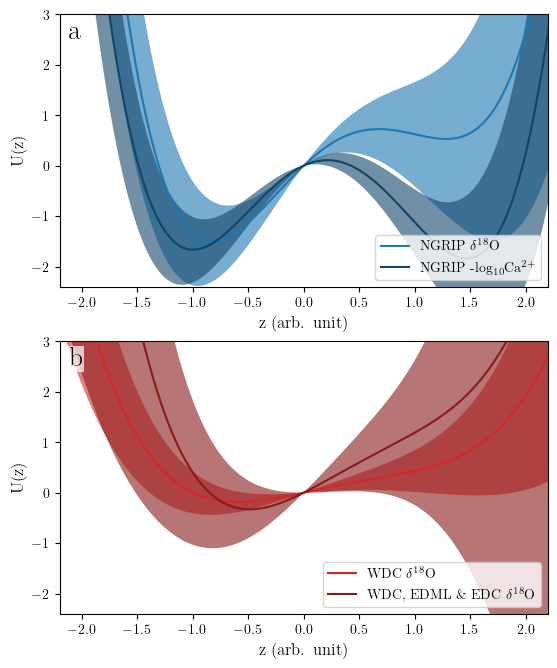

In [25]:
fig, ax = plt.subplots(2, 1, figsize=set_size(width, fraction=1, subplots=(2, 1)))

#1: -60 to -25 #2: -52 to -25
#ant_st hat probleme. -60 wird nicht erkannt [4] (5. wert) ist 1e-06

ngrip_moving_mid = [2.086373802996205, -1.0865219365390097, -1.1042834351457467, 0.7282500419175466, 0.1813224458621301, 3.283548568372904, 1207.3539421864514, 2426.7078843729028, 2459.512110774408]
ngrip_moving_mid_hess = [0.8385668049910519, 0.5528508062124027, 0.20781192607443275, 0.11150601799394691, 0.02320348784700315, 0.13884398955524407]
ngrip_moving_mid2 = [3.208990548364978, -0.7802004131720961, -1.2462996771722292, 0.6377164478986818, 0.20042104542589217, 3.191742294201688, 923.0913069716248, 1858.1826139432496, 1889.4297731718445]
cal_moving_mid = [1.0065279125582232, -2.194511628569978, -0.7325512247876341, 0.8034918301781504, 0.047638377350670946, 1.7478600278817504, -10.867289660068764, -9.734579320137527, 23.069647081367833]
cal_moving_mid_hess = [0.5192990964747032, 0.35112683483047497, 0.14325059892418188, 0.09493667861130235, 0.014154406697787168, 0.0529407598827429]
cal_moving_mid2 = [0.9154782590958467, -1.5422598606951783, -0.5849672454869673, 0.6046915669116384, 0.06908464159533032, 1.5990024953940196, -41.67783521754859, -71.35567043509718, -40.10851120650233]
wdc_moving_mid = [0.45614649063798063, 0.04155895646818852, -0.2448343645600314, 0.1749529425327778, 0.3382519627903657, 1.2418435781031931, 981.751883811551, 1975.503767623102, 2008.3079940246073]
wdc_moving_mid_hess = [0.3026538307757259, 0.24832679933242552, 0.1104137234815227, 0.07233276231596968, 0.009472879324188815, 0.09207146178358175]
wdc_moving_mid2 = [0.4202407697445213, -0.06747445759200134, -0.23892598222717437, 0.16193368120314636, 0.37587126841303975, 1.153250953491953, 836.4995517451796, 1684.9991034903592, 1716.246262718954]
stack_moving_mid = [1.1062440984363628, 0.4519448756032385, -0.7130144967727156, 0.34239777519576287, 1e-06, 2.2480731909695746, 401.68027303101417, 815.3605460620283, 848.1647724635337]
stack_moving_mid_hess = [0.5282046743171093, 0.38325145532510224, 0.1694470401058487, 0.08743953135076936, 0.0322503579696157, 0.03963835734031939]
stack_moving_mid2 = [1.5215302632521757, 0.08496275067110697, -0.8644350176906567, 0.421935170931186, 0.030366698286713546, 2.3511545360971655, 369.17189845697885, 750.3437969139577, 781.5909561425526]

var = ngrip_moving_mid
ax[0].plot(xx, plot_potential(xx, var),  c = colors['ngrip'], label = "NGRIP $\delta^{18}$O")
plot_std_(ax[0], ngrip_moving_mid, ngrip_moving_mid_hess, color = colors['ngrip'])
#var = ngrip_moving_mid2
#ax[1].plot(xx, plot_potential(xx, var),  c = colors['ngrip'], label = "NGRIP $\delta^{18}$O")

var = cal_moving_mid
ax[0].plot(xx, plot_potential(xx, var),  c = colors['cal'], label = "NGRIP -log$_{10}$Ca$^{2+}$")
plot_std_(ax[0], cal_moving_mid, cal_moving_mid_hess, color = colors['cal'])
#var = cal_moving_mid2
#ax[1].plot(xx, plot_potential(xx, var),  c = colors['cal'], label = "NGRIP -log$_{10}$Ca$^{2+}$")

var = wdc_moving_mid
ax[1].plot(xx, plot_potential(xx, var), c = colors['wdc'],  label = "WDC $\delta^{18}$O")
plot_std_(ax[1], wdc_moving_mid, wdc_moving_mid_hess, color = colors['wdc'])
#var = wdc_moving_mid2
#ax[1].plot(xx, plot_potential(xx, var), c = colors['wdc'],  label = "WDC $\delta^{18}$O")

var = stack_moving_mid
ax[1].plot(xx, plot_potential(xx, var),  c = colors['stack'], label = "WDC, EDML $\&$ EDC $\delta^{18}$O")
plot_std_(ax[1], stack_moving_mid, stack_moving_mid, color = colors['stack'])
#var = stack_moving_mid2
#ax[1].plot(xx, plot_potential(xx, var),  c = colors['stack'], label = "WDC, EDML $\&$ EDC $\delta^{18}$O")


for i in range(2):
    ax[i].legend(loc = 4)
    ax[i].set_xlim(-2.2,2.2)
    ax[i].set_ylim(-2.4,3)
    
ax[0].set_xlabel('z (arb. unit)')
ax[0].set_ylabel('U(z)')
ax[1].set_xlabel('z (arb. unit)')
ax[1].set_ylabel('U(z)')
    
abstand_prozent = 0.02
ax_text = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
for i, ax in enumerate((ax[0], ax[1])):
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    x_abstand = (xlim[1] - xlim[0]) * abstand_prozent
    y_abstand = (ylim[1] - ylim[0]) * abstand_prozent
    ax.text(xlim[0] + x_abstand, ylim[1] - y_abstand, ax_text[i], va='top', ha='left', size = 20, bbox=dict(facecolor='white', alpha=0.7, edgecolor = 'none', pad = 0.5))
    #ax.text(0,ylim[1] - y_abstand, ["60 to 25 kyr BP","52 to 25 kyr BP"][i], va='top', ha='center', size = 20)

fig.savefig('C:/Users/morit/Documents/Masterarbeit/output_M/real_data.jpg', format='jpg', dpi=600, bbox_inches='tight')

plt.show()

In [26]:
fun = wdc_moving_mid[6]
print(fun)
k = 6
data = data_cut(ant_st_, -60, -25)[1]

aic = 2*(k + fun)
bic = 2*fun + k*np.log(len(data)-50)

print(aic, bic)
print(ngrip_moving_mid[7:])

981.751883811551
1975.503767623102 2008.1340688033679
[2426.7078843729028, 2459.512110774408]


In [27]:
north_true = subtract_moving(cal_, 516, "mid")
south_true = subtract_moving(wd_, 516, "mid")

num_steps = len(north_true)


[1.28319853 0.05      ]
[1.26179047 0.1       ]
[1.23390198 0.15      ]
[1.20319585 0.2       ]


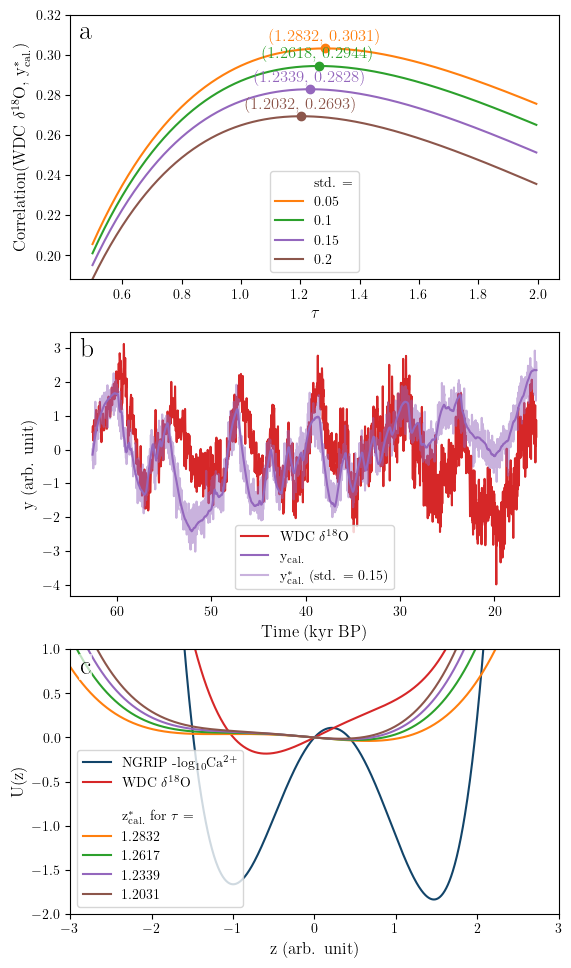

In [28]:
fig, ax = plt.subplots(3, 1, figsize=set_size(width, fraction=1, subplots=(3, 1)))

xx = np.arange(-4, 4, 0.005)

t = [abs(i) for i in t]

#alpha = 0.05 white noise
calculated_south005 = [-0.08159911413838165, -0.014035581335519503, 0.054516034595374796, 0.026581063266728967, 0.1040350534808498, 0.493207258396385, -878.2800022401102, -1744.5600044802204, -1711.7557780787151]
#alpha = 0.1 white noise
calculated_south01 = [-0.08487032077414895, 0.008852730958729104, 0.07632579609113176, 0.035474953583191575, 0.21577242939893287, 0.5997993297181653, 132.6378597481687, 277.2757194963374, 310.0799458978428]
#alpha = 0.15 white noise
calculated_south015 = [-0.08086465372909052, 0.032424408901801365, 0.09074749465336253, 0.04135602997221168, 0.31833367924683914, 0.657528302119745, 708.1110054712933, 1428.2220109425866, 1461.026237344092]
#alpha = 0.2 white noise
calculated_south02 = [-0.07416357751138099, 0.05515481437016746, 0.10201126039319607, 0.04625838608044857, 0.40961714197214655, 0.6886578345447243, 1090.1958542260654, 2192.391708452131, 2225.195934853636]

color_j = [colors['col1'], colors['col2'], colors['col3'], colors['col4']]
ax[0].plot(1,0.2, alpha = 0, label="std. = ")
for u, j in enumerate([0.05, 0.1, 0.15, 0.2]):
    taus = np.arange(0.5,2, 0.005)
    corr = []

    lo = np.array([taus.min(), j])
    up = np.array([taus.max(), 1])

    corr_min = minimize(correlation, [0.01, 0.001], method="L-BFGS-B", bounds=list(zip(lo, up)))
    print(corr_min.x)

    for i in taus:
        corr.append(-1*correlation([i, corr_min.x[1]]))

    ax[0].plot(taus, corr, label = str(j), c = color_j[u])

    ax[0].scatter(corr_min.x[0], -corr_min.fun, c = color_j[u])
    ax[0].text(corr_min.x[0], -corr_min.fun+0.002, f'({np.round(corr_min.x[0],4)}, {-np.round(corr_min.fun,4)})', ha='center', va='bottom', c = color_j[u])

ax[0].set_ylim(corr[0],0.32)
ax[0].legend(loc = 8) 
ax[0].set_xlabel(r'$\tau$')
ax[0].set_ylabel(r'Correlation(WDC $\delta^{18}$O, y$_\mathrm{cal.}^*$)')

tau = 1.23390213
S = np.zeros(num_steps)
N = np.zeros(num_steps)

S[0]  = north_true[0]
N[0]  = north_true[0]

random.seed(1)
for i in range(1, num_steps):
    S[i] = S[i-1] - (dT/tau) * (N[i-1] + S[i-1])
    N[i] = north_true[i]
    
S_ = add_noise(S, 0.15, 1)

ax[1].plot(t[int(516/2):-int(516/2)], list((south_true-np.mean(south_true))/np.std(south_true))[int(516/2):-int(516/2)], label = 'WDC $\delta^{18}$O', c = colors['wdc'], zorder = 1)
ax[1].plot(t[int(516/2):-int(516/2)], list((S-np.mean(S))/np.std(S))[int(516/2):-int(516/2)], label = 'y$_\mathrm{cal.}$', c = colors['col3'], zorder = 3)
ax[1].plot(t[int(516/2):-int(516/2)], list((S_-np.mean(S_))/np.std(S_))[int(516/2):-int(516/2)], label = 'y$_\mathrm{cal.}^*$ (std. = 0.15)', c = colors['col3'], alpha = 0.5, zorder = 2)
ax[1].legend()

ax[1].set_xlabel("Time (kyr BP)")
ax[1].set_ylabel('y (arb. unit)')

var = cal_moving_mid
plt.plot(xx, plot_potential(xx, var), c = colors['cal'], label = "NGRIP -log$_{10}$Ca$^{2+}$")
var = wdc_moving_mid
plt.plot(xx, plot_potential(xx, var),  c = colors['wdc'], label = "WDC $\delta^{18}$O")

plt.plot(0, 0, alpha = 0, label = '\n' + r'z$_\mathrm{cal.}^*$ for $\tau$ = ')
var = calculated_south005
plt.plot(xx, plot_potential(xx, var),  c = colors['col1'], label = '1.2832')
var = calculated_south01
plt.plot(xx, plot_potential(xx, var), c = colors['col2'], label = "1.2617")
var = calculated_south015
plt.plot(xx, plot_potential(xx, var),  c = colors['col3'], label = "1.2339")
var = calculated_south02
plt.plot(xx, plot_potential(xx, var), c = colors['col4'], label = "1.2031")

plt.legend()
plt.ylim(-2,1)
plt.xlim(-3,3)

ax[2].set_xlabel('z (arb. unit)')
ax[2].set_ylabel('U(z)')

ax[1].invert_xaxis()

abstand_prozent = 0.02
ax_text = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
for i, ax in enumerate((ax[0], ax[1], ax[2])):
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    x_abstand = (xlim[1] - xlim[0]) * abstand_prozent
    y_abstand = (ylim[1] - ylim[0]) * abstand_prozent
    ax.text(xlim[0] + x_abstand, ylim[1] - y_abstand, ax_text[i], va='top', ha='left', size = 20, bbox=dict(facecolor='white', alpha=0.7, edgecolor = 'none', pad = 0.5))
    
fig.savefig('C:/Users/morit/Documents/Masterarbeit/output_M/stocker.jpg', format='jpg', dpi=600, bbox_inches='tight')

plt.show()
t = [-i for i in t]

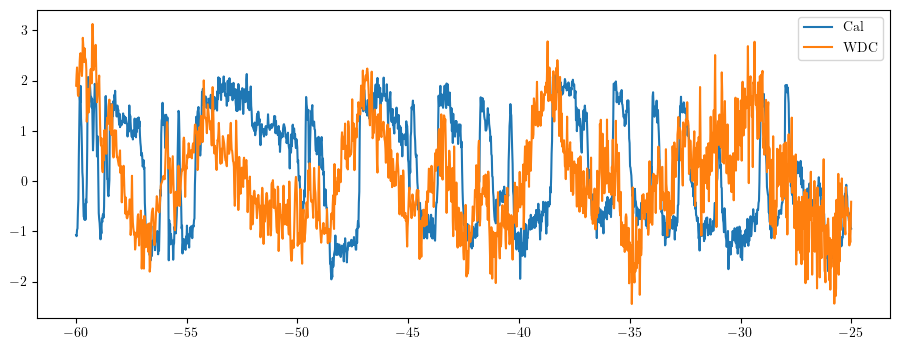

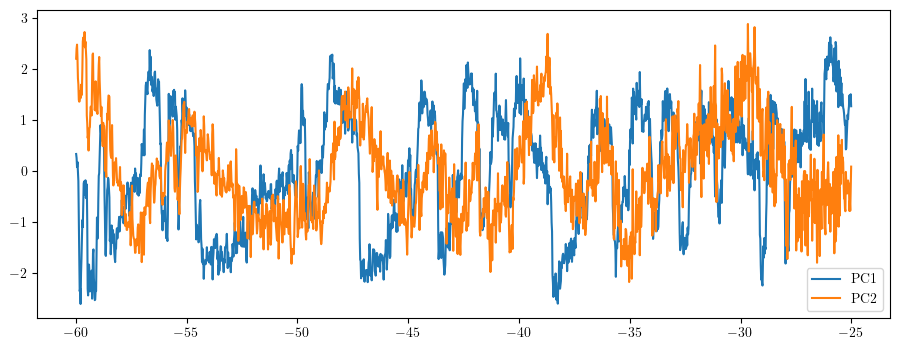

PCA1: [-0.89 -0.45]
PCA2: [-0.45  0.89]
Varianz:   [60.72 39.28] %


In [29]:
dT = 0.02
t = np.arange(-67.73, -10.4, dT)
t_ = [x for x in t]

#load data
data1 = cal_ 
data2 = wd_

#subract forcing
data1 = list(subtract_moving(data1, 516, "mid"))
data1_ = data1
data2 = list(subtract_moving(data2, 516, "mid"))

#normalize
#data1 = data1-np.mean(data1)
#data2 = data2-np.mean(data2)
data1 = (data1-np.mean(data1))/np.std(data1)
data2 = (data2-np.mean(data2))/np.std(data2)

cut_a, cut_b = -60, -25

#cut 
#lag = (208+218)/2/1000
#data1 = data_cut(data1,cut_a,cut_b)[1]
#data2 = data_cut(data2,cut_a+lag,cut_b+lag)[1]
#lag = 23
#data1 = data_cut(data1,cut_a,cut_b)[1]
#data2 = data_cut(data2[:-lag],cut_a-lag*dT,cut_b-lag*dT)[1]
data1 = data_cut(data1,cut_a,cut_b)[1]
data2 = data_cut(data2,cut_a,cut_b)[1]

ref_direction = PCA_(data1, data2, None, None)[1]

#plot PCA
plt.plot(data_cut(data1,cut_a,cut_b)[0], data1, label = "Cal")
plt.plot(data_cut(data1,cut_a,cut_b)[0], data2, label = "WDC")
plt.legend()
plt.show()

plt.plot(data_cut(data1,cut_a,cut_b)[0], PCA_(data1, data2, 0, ref_direction)[0], label = "PC1")
plt.plot(data_cut(data1,cut_a,cut_b)[0], PCA_(data1, data2, 1, ref_direction)[0], label = "PC2")
plt.legend()

plt.show()

combined_data = np.vstack((data1, data2)).T
pca = PCA(n_components=2)
pca_result = pca.fit_transform(combined_data)

#Hauptkomponenten sind Vektoren im Merkmalsraum und definieren die Richtungen mit maximaler Varianz in den Daten.
print("PCA1: " + str(PCA_(data1, data2, 0, ref_direction)[1][0])) #1.ste Hauptkomponente
print("PCA2: " + str(PCA_(data1, data2, 0, ref_direction)[1][1])) #2.te Hauptkomponente

print("Varianz:   " + str(PCA_(data1, data2, 0, ref_direction)[2]) + " %")

In [30]:
def normalize(data):
    return (data-np.mean(data))

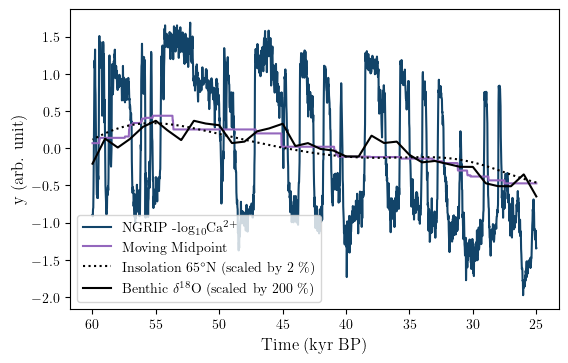

In [31]:
fig, ax = plt.subplots(1, 1, figsize=set_size(width, fraction=1, subplots=(1, 1)))

dT = 0.02
t = np.arange(-67.73, -10.4, dT)
t_ = [x for x in t]
plot_time = np.arange(25, 60, dT)

plt.plot(plot_time, normalize(data_cut(cal_,-60,-25)[1][::-1]), color = colors['cal'], label = "NGRIP -log$_{10}$Ca$^{2+}$")
plt.plot(plot_time, normalize(data_cut(cal_-data1_,-60,-25)[1][::-1]), color = colors['mid'], label = "Moving Midpoint")

plt.plot(plot_time, normalize(data_cut(soln_*0.02, -60, -25)[1][::-1]), linestyle = 'dotted', color = 'k', label = r'Insolation 65$^\circ$N (scaled by 2 $\%$)')
plt.plot(plot_time, normalize(data_cut(-benthic_*2, -60, -25)[1][::-1]), 'k', label = 'Benthic $\delta^{18}$O (scaled by 200 $\%$)')
plt.legend()
plt.gca().invert_xaxis()

plt.xlabel('Time (kyr BP)')
plt.ylabel('y (arb. unit)')

fig.savefig('C:/Users/morit/Documents/Masterarbeit/output_M/real_forcing_vs_inso.jpg', format='jpg', dpi=600, bbox_inches='tight')

plt.show()

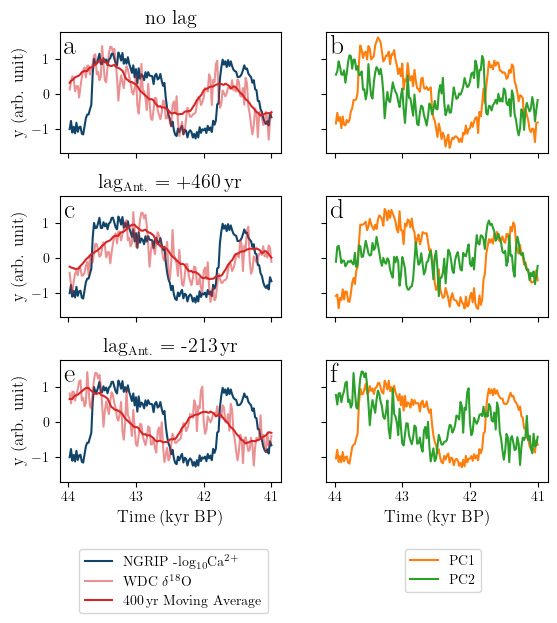

In [32]:
fig, ax = plt.subplots(3, 2, figsize=set_size(width, fraction=1, subplots=(3, 2)), sharey = True, sharex = True)

dT = 0.02
t = np.arange(-67.73, -10.4, dT)
t_ = [x for x in t]
plot_time = np.arange(41, 44, dT)

ax[0][0].plot(plot_time, normalize(data_cut(cal_,-44,-41)[1][::-1]), color = colors['cal'], label = "NGRIP -log$_{10}$Ca$^{2+}$")
ax[0][0].plot(plot_time, normalize(data_cut(wd_,-44,-41)[1][::-1]), color = colors['wdc'], alpha = 0.5, label = "WDC $\delta^{18}$O")

ax[0][0].plot(plot_time, (normalize(data_cut(wd_,-45,-40)[1][::-1]) - 
                             subtract_moving(normalize(data_cut(wd_,-45,-40)[1][::-1]), 20, 'avg'))[50:-50],
        color = colors['wdc'], label = r'400\,yr Moving Average')

ax[0][1].plot(plot_time, PCA_(normalize(data_cut(cal_,-44,-41)[1][::-1]), 
                              normalize(data_cut(wd_,-44,-41)[1][::-1]), 0, None)[0], colors['col1'], label = "PC1")
ax[0][1].plot(plot_time, -PCA_(normalize(data_cut(cal_,-44,-41)[1][::-1]), 
                              normalize(data_cut(wd_,-44,-41)[1][::-1]), 1, None)[0], colors['col2'], label = "PC2")

ax[0][0].invert_xaxis()
ax[0][1].invert_xaxis()


dT = 0.02
t = np.arange(-67.73, -10.4, dT)
t_ = [x for x in t]
plot_time = np.arange(41, 44, dT)

lag = 23
ax[1][0].plot(plot_time, normalize(data_cut(cal_,-44,-41)[1][::-1]), color = colors['cal'], label = "NGRIP -log$_{10}$Ca$^{2+}$")
ax[1][0].plot(plot_time, normalize(data_cut(wd_[:-lag],-44-lag*dT,-41-lag*dT)[1][::-1]), color = colors['wdc'], alpha = 0.5, label = "WDC $\delta^{18}$O")

ax[1][0].plot(plot_time, (normalize(data_cut(wd_[:-lag],-45-lag*dT,-40-lag*dT)[1][::-1]) - 
                             subtract_moving(normalize(data_cut(wd_[:-lag],-45-lag*dT,-40-lag*dT)[1][::-1]), 20, 'avg'))[50:-50],
        color = colors['wdc'], label = r'400\,yr Moving Average')

ax[1][1].plot(plot_time, -PCA_(normalize(data_cut(cal_,-44,-41)[1][::-1]), 
                              normalize(data_cut(wd_[:-lag],-44-lag*dT,-41-lag*dT)[1][::-1]), 0, None)[0], colors['col1'], label = "PC1")
ax[1][1].plot(plot_time, -PCA_(normalize(data_cut(cal_,-44,-41)[1][::-1]), 
                              normalize(data_cut(wd_[:-lag],-44-lag*dT,-41-lag*dT)[1][::-1]), 1, None)[0], colors['col2'], label = "PC2")

ax[1][0].invert_xaxis()
ax[1][1].invert_xaxis()


dT = 0.02
t = np.arange(-67.73, -10.4, dT)
t_ = [x for x in t]
plot_time = np.arange(41, 44, dT)

lag = (208+218)/2/1000
ax[2][0].plot(plot_time, normalize(data_cut(cal_,-44,-41)[1][::-1]), color = colors['cal'], label = "NGRIP -log$_{10}$Ca$^{2+}$")
ax[2][0].plot(plot_time, normalize(data_cut(wd_,-44+lag,-41+lag)[1][::-1]), color = colors['wdc'], alpha = 0.5, label = "WDC $\delta^{18}$O")

ax[2][0].plot(plot_time, (normalize(data_cut(wd_,-45+lag,-40+lag)[1][::-1]) - 
                             subtract_moving(normalize(data_cut(wd_,-45+lag,-40+lag)[1][::-1]), 20, 'avg'))[50:-50],
        color = colors['wdc'], label = r'400\,yr Moving Average')

ax[2][1].plot(plot_time, -PCA_(normalize(data_cut(cal_,-44,-41)[1][::-1]), 
                              normalize(data_cut(wd_,-44+lag,-41+lag)[1][::-1]), 0, None)[0], colors['col1'], label = "PC1")
ax[2][1].plot(plot_time, PCA_(normalize(data_cut(cal_,-44,-41)[1][::-1]), 
                              normalize(data_cut(wd_,-44+lag,-41+lag)[1][::-1]), 1, None)[0], colors['col2'], label = "PC2")

ax[2][0].set_xlabel('Time (kyr BP)')
ax[2][1].set_xlabel('Time (kyr BP)')
ax[0][0].set_ylabel('y (arb. unit)')
ax[1][0].set_ylabel('y (arb. unit)')
ax[2][0].set_ylabel('y (arb. unit)')


ax[0][0].legend(bbox_to_anchor=(.97,-3.2))
ax[0][1].legend(bbox_to_anchor=(0.73,-3.2))

ax[0][0].set_title('no lag')
ax[1][0].set_title(r'lag$_\textup{\small{Ant.}}$ = +460\,yr')
ax[2][0].set_title(r'lag$_\textup{\small{Ant.}}$ = -213\,yr')

plt.subplots_adjust(hspace=.35)

ax[2][0].invert_xaxis()
ax[2][1].invert_xaxis()

plt.gca().invert_xaxis()


abstand_prozent = 0.02
ax_text = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
for i, ax in enumerate((ax[0][0], ax[0][1], ax[1][0], ax[1][1], ax[2][0], ax[2][1])):
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    x_abstand = (xlim[1] - xlim[0]) * abstand_prozent
    y_abstand = (ylim[1] - ylim[0]) * abstand_prozent
    ax.text(xlim[0] + x_abstand, ylim[1] - y_abstand, ax_text[i], va='top', ha='left', size = 20, bbox=dict(facecolor='white', alpha=0.7, edgecolor = 'none', pad = 0.5))

fig.savefig('C:/Users/morit/Documents/Masterarbeit/output_M/data_lag.jpg', format='jpg', dpi=600, bbox_inches='tight')

plt.show()

In [ ]:
PCA0_cal_wdc_std = [0.33159241715833326, -0.4335313683133792, -0.10142393604823687, 0.21688605149298787, 0.1300679664705371, 1.8329171793998429, 400.15986680111746, 812.3197336022349, 845.1239600037403, 60.72, "$(-0.89, -0.45)$"]
PCA0_cal_wdc_std_h [0.4552264474872779, 0.29133921460128753, 0.08601320941780073, 0.0526881104799894, 0.009007951547909007, 0.06310097286630853]


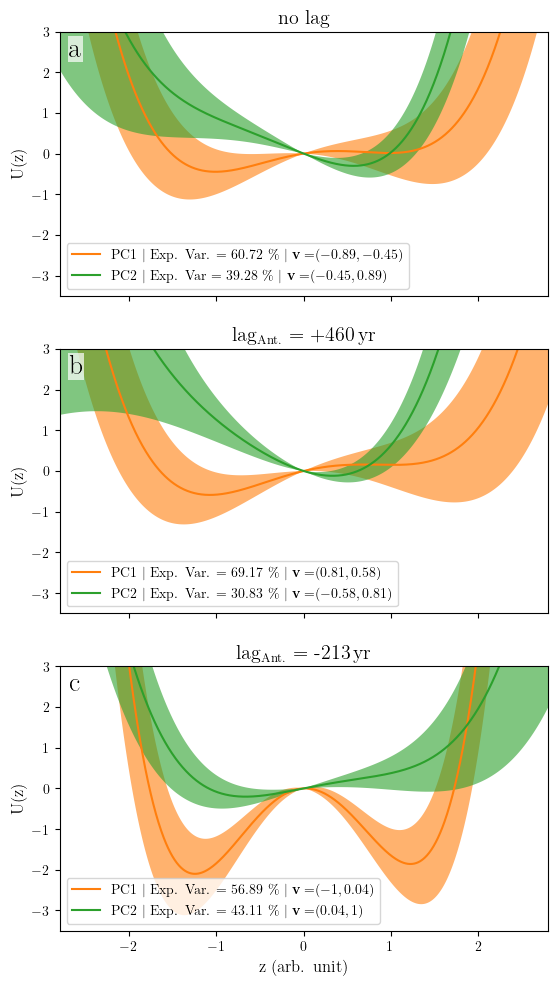

In [33]:
fig, ax = plt.subplots(3, 1, figsize=set_size(width, fraction=1, subplots=(3, 1)), sharex = True)


PCA0_cal_wdc_std = [0.33159241715833326, -0.4335313683133792, -0.10142393604823687, 0.21688605149298787, 0.1300679664705371, 1.8329171793998429, 400.15986680111746, 812.3197336022349, 845.1239600037403, 60.72, "$(-0.89, -0.45)$"]
PCA0_cal_wdc_std_hess = [0.4552264474872779, 0.29133921460128753, 0.08601320941780073, 0.0526881104799894, 0.009007951547909007, 0.06310097286630853]
PCA1_cal_wdc_std = [-0.8333497992202147, 0.2286159282089867, 0.411839150659748, 0.2198928317607403, 0.2822749448543992, 1.5436588191679388, 866.2888563314455, 1744.577712662891, 1777.3819390643962, 39.28, "$(-0.45, 0.89$)"]
PCA1_cal_wdc_std_hess = [0.377309638002931, 0.3025367079384507, 0.13699027992692764, 0.08434969050320898, 0.009947903564075817, 0.09675912125845262]

var = PCA0_cal_wdc_std
ax[0].plot(xx, plot_potential(xx, var), label = "PC1 $|$ Exp. Var. = " + str(var[-2]) + " \% $|$ " + r"$\textbf{v} = $" + str(var[-1]), color = colors["col1"])
plot_std_(ax[0], PCA0_cal_wdc_std, PCA0_cal_wdc_std_hess, color = colors["col1"])
var = PCA1_cal_wdc_std
ax[0].plot(xx, plot_potential(xx, var), label = "PC2 $|$ Exp. Var = " + str(var[-2]) + " \% $|$ " + r"$\textbf{v} = $" + str(var[-1]), color = colors["col2"])
plot_std_(ax[0], PCA1_cal_wdc_std, PCA1_cal_wdc_std_hess, color = colors["col2"])


PCA0_cal_wdc_lagged_corr = [0.5067860993038417, -0.3850761178366501, -0.1412347473895248, 0.1694291578219089, 0.15661172319285951, 1.8622391439766606, 525.242242892291, 1062.484485784582, 1095.2887121860872, 69.17, "$(0.81, 0.58)$" ]
PCA0_cal_wdc_lagged_corr_hess = [0.4557731653089746, 0.281420962404824, 0.07696605952266608, 0.04406189555294457, 0.009429240278405037, 0.07087245216165501]
#PCA0_cal_wdc_lagged_corr =[-0.4962283743688157, -0.3677252418108108, 0.12165740782271056, 0.17005702745613688, 0.15408795476267798, 1.925867951007917, 552.2766800862183, 1116.5533601724367, 1149.357586573942, 68.18, "$(0.81, 0.59)$" ]
PCA1_cal_wdc_lagged_corr = [-0.6624385335740227, 0.7954008966219929, 0.34804150787160254, 0.14583443936759602, 0.25874007768984564, 1.5670206591235716, 779.7618885147697, 1571.5237770295394, 1604.3280034310446, 30.83, "$(-0.58,  0.81)$"]
PCA1_cal_wdc_lagged_corr_hess = [0.3562067625360862, 0.3634508428540413, 0.1462491475925262, 0.10936362865026612, 0.009157098540751429, 0.08698233666802169]
#PCA1_cal_wdc_lagged_corr = [-0.7372997815044701, 0.8594349225445055, 0.3823301540676153, 0.1065086839638254, 0.2537111826571154, 1.6132901842242195, 780.6437672221185, 1573.287534444237, 1606.0917608457423, 31.82, "$(-0.59,  0.81)$"]

var = PCA0_cal_wdc_lagged_corr
ax[1].plot(xx, plot_potential(xx, var), label = "PC1 $|$ Exp. Var. = " + str(var[-2]) + " \% $|$ " + r"$\textbf{v} = $" + str(var[-1]), color = colors["col1"])
plot_std_(ax[1], PCA0_cal_wdc_lagged_corr, PCA0_cal_wdc_lagged_corr_hess, color = colors["col1"])
var = PCA1_cal_wdc_lagged_corr
ax[1].plot(xx, plot_potential(xx, var), label = "PC2 $|$ Exp. Var. = " + str(var[-2]) + " \% $|$ " + r"$\textbf{v} = $" + str(var[-1]), color = colors["col2"])
plot_std_(ax[1], PCA1_cal_wdc_lagged_corr, PCA1_cal_wdc_lagged_corr_hess, color = colors["col2"])

# first one was old pca_, second one is with ref_direction to the first one
PCA0_cal_wdc_std_seesaw = [0.08980018279974507, -2.589987285703492, 0.005303592190519094, 0.8476844180670948, 0.04793845755255789, 1.752408682450133, -11.68317868209374, -11.366357364187479, 21.43786903731788,  56.89, "$(-1,   0.04)$"]
PCA0_cal_wdc_std_seesaw_hess = [0.521904633426089, 0.3760237570136372, 0.11681810496640443, 0.09814018250620812, 0.014212818284579288, 0.05356186392306117]
#PCA0_cal_wdc_std_seesaw = [-0.08980018279974507, -2.589987285703492, -0.005303592190519094, 0.8476844180670948, 0.04793845755255789, 1.752408682450133, -11.68317868209374, -11.366357364187479, 21.43786903731788,  56.89, "$(-1,   0.04)$"]
PCA1_cal_wdc_std_seesaw = [0.4225899169790357, -0.02880850687207732, -0.19313196817958547, 0.17301465286040218, 0.34061642284310484, 1.2272898042407319, 986.737471129605, 1985.47494225921, 2018.2791686607152, 43.11, "$(0.04, 1  )$"]
PCA1_cal_wdc_std_seesaw_hess = [0.2957446054182175, 0.25142125631420437, 0.09883051376694144, 0.07214572136483512, 0.009452976078704139, 0.09178414902605066]
#PCA1_cal_wdc_std_seesaw = [-0.4225899169790357, -0.02880850687207732, 0.19313196817958547, 0.17301465286040218, 0.34061642284310484, 1.2272898042407319, 986.737471129605, 1985.47494225921, 2018.2791686607152, 43.11, "$(0.04, 1  )$"]

var = PCA0_cal_wdc_std_seesaw
ax[2].plot(xx, plot_potential(xx, var), label = "PC1 $|$ Exp. Var. = " + str(var[-2]) + " \% $|$ " + r"$\textbf{v} = $" + str(var[-1]), color = colors["col1"])
plot_std_(ax[2], PCA0_cal_wdc_std_seesaw, PCA0_cal_wdc_std_seesaw_hess, color = colors["col1"])
var = PCA1_cal_wdc_std_seesaw
ax[2].plot(xx, plot_potential(xx, var), label = "PC2 $|$ Exp. Var. = " + str(var[-2]) + " \% $|$ " + r"$\textbf{v} = $" + str(var[-1]), color = colors["col2"])
plot_std_(ax[2], PCA1_cal_wdc_std_seesaw, PCA1_cal_wdc_std_seesaw_hess, color = colors["col2"])

ax[2].set_xlabel('z (arb. unit)')
for i in range(3):
    ax[i].set_ylabel('U(z)')
    
abstand_prozent = 0.02
ax_text = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
for i, ax in enumerate((ax[0], ax[1], ax[2])):
    ax.set_title(['no lag', r'lag$_\textup{\small{Ant.}}$ = +460\,yr', r'lag$_\textup{\small{Ant.}}$ = -213\,yr'][i])
    ax.legend(loc = 3)
    ax.set_xlim(-2.8,2.8)
    ax.set_ylim(-3.5,3)
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    x_abstand = (xlim[1] - xlim[0]) * abstand_prozent
    y_abstand = (ylim[1] - ylim[0]) * abstand_prozent
    ax.text(xlim[0] + x_abstand, ylim[1] - y_abstand, ax_text[i], va='top', ha='left', size = 20, bbox=dict(facecolor='white', alpha=0.7, edgecolor = 'none', pad = 0.5))
    
fig.savefig('C:/Users/morit/Documents/Masterarbeit/output_M/PCA_real_data.jpg', format='jpg', dpi=600, bbox_inches='tight')

plt.show()

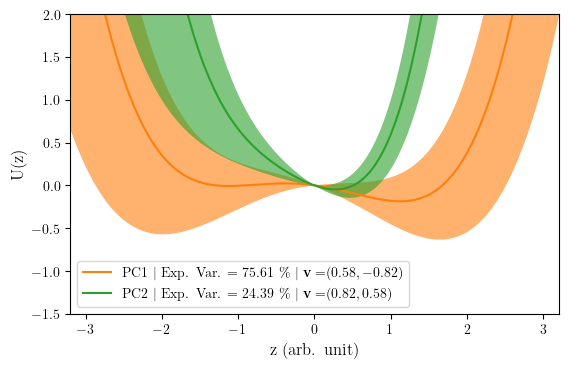

In [34]:
fig, ax = plt.subplots(1, 1, figsize=set_size(width, fraction=1, subplots=(1, 1)))

PCA0_cal_stocker = [-0.11923533873229988, -0.1541554342052408, 0.03145190193377366, 0.06135479939096729, 0.112925006914424, 0.9140949811080592, -379.07097690045157, -746.1419538009031, -713.3377273993977, 75.61, "$(0.58, -0.82)$"]
PCA0_cal_stocker_hess = [0.22418865435441165, 0.14826322670336742, 0.04307586169433738, 0.02662079746144859, 0.003917212402729037, 0.032625681766081834]
PCA1_cal_stocker = [-0.3124959292453288, 0.4118533085590859, 0.28015104753436854, 0.21323936669921603, 0.08476612365230474, 1.0857582463901139, -430.157702850913, -848.315405701826, -815.5111793003206, 24.39, "$(0.82, 0.58)$"]
PCA1_cal_stocker_hess = [0.24148761599206484, 0.26879122403760375, 0.14406323754318204, 0.11293359864878323, 0.004701379169729143, 0.03493222527551755]

var = PCA0_cal_stocker
plt.plot(xx, plot_potential(xx, var), label = "PC1 $|$ Exp. Var. = " + str(var[-2]) + " \% $|$ " + r"$\textbf{v} = $" + str(var[-1]), color = colors["col1"])
plot_std_(plt, PCA0_cal_stocker, PCA0_cal_stocker_hess, color = colors["col1"])
var = PCA1_cal_stocker
plt.plot(xx, plot_potential(xx, var), label = "PC2 $|$ Exp. Var. = " + str(var[-2]) + " \% $|$ " + r"$\textbf{v} = $" + str(var[-1]), color = colors["col2"])
plot_std_(plt, PCA1_cal_stocker, PCA1_cal_stocker_hess, color = colors["col2"])

plt.legend(loc = 3)
plt.xlim(-3.2,3.2)
plt.ylim(-1.5,2)

plt.xlabel('z (arb. unit)')
plt.ylabel('U(z)')

fig.savefig('C:/Users/morit/Documents/Masterarbeit/output_M/PCA_stocker.jpg', format='jpg', dpi=600, bbox_inches='tight')

plt.show()

# Discussion

In [35]:
#emb_dim = int(2*np.pi/0.25/dT)
#func1_SSA_1 = SSA(func1,emb_dim,1,0,1)
#func1_SSA_1.to_csv('func1_SSA_1.csv', index=False)

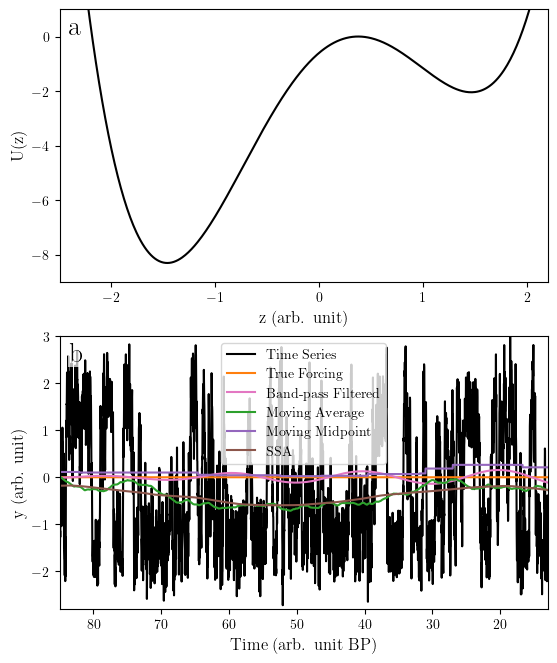

In [36]:
fig, ax = plt.subplots(2, 1, figsize=set_size(width, fraction=1, subplots=(2, 1)))

dT = 0.02
h = 0.001
L = int(dT/h)
t = np.arange(-97.9, 0, dT) 
n = len(t) 
t_ = [x for x in t]

t = [abs(i) for i in t]

p = [0, -4, 1, 1, 0, 3.5]
z = 1

shift_x = 3/8

for i in range(1):
    y = [0] * n  
    random.seed(i)                     
    y[0] = z + random.gauss(0, p[4])    
    for k in range(1, n):
        for l in range(int(L)):
            z = z - h*(4 * p[3]*z**3 + 3*p[2]*z**2 + 2*p[1]*z + p[0]) + random.gauss(0, p[5] * np.sqrt(h))
        y[k] = z + random.gauss(0, p[4])
        
func1 = [y+shift_x for y in y]

window_size=1250

moveavg = moving_average(func1, window_size)
moveavg = np.pad(moveavg, (int(window_size/2), int(window_size/2-1)), mode='constant', constant_values=0)

movemid = moving_midpoint(func1, window_size)
movemid = np.pad(movemid, (int(window_size/2), int(window_size/2-1)), mode='constant', constant_values=0)

tss = np.arange(-5,5,0.01)

ax[0].plot(tss, [(x-shift_x)**4+(x-shift_x)**3-4*(x-shift_x)**2 for x in tss], "k")
ax[0].set_xlim(-2.5,2.2)
ax[0].set_ylim(-9,1)
ax[0].set_xlabel('z (arb. unit)')
ax[0].set_ylabel('U(z)')
#ax[0].scatter(- np.sqrt(137)/8, 1/512*(-2651-137*np.sqrt(137))) 
#ax[0].scatter(  np.sqrt(137)/8, 1/512*(-2651+137*np.sqrt(137))) 
#ax[0].scatter(0, -2439/4096) 

plt.plot(t,func1, c = 'k', label = "Time Series")
plt.plot(t, [0 for t in t], c = colors['col1'], label = "True Forcing")
series_forced = func1
plt.plot(t, return_band_pass([0.301, 0.32715877], 2), c = colors['high'], label = "Band-pass Filtered")
plt.plot(t, moveavg, c = colors['avg'], label = "Moving Average")
plt.plot(t, movemid, c = colors['mid'], label = "Moving Midpoint")
plt.plot(t, pd.read_csv('func1_SSA_1.csv'), c = colors['ssa'], label = "SSA")


plt.xlim(13, 85)
plt.ylim(-2.8, 3)
plt.xlabel('Time (arb. unit BP)')
plt.ylabel('y (arb. unit)')
plt.legend()

plt.gca().invert_xaxis()

abstand_prozent = 0.02
ax_text = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
for i, ax in enumerate((ax[0], ax[1])):
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    x_abstand = (xlim[1] - xlim[0]) * abstand_prozent
    y_abstand = (ylim[1] - ylim[0]) * abstand_prozent
    ax.text(xlim[0] + x_abstand, ylim[1] - y_abstand, ax_text[i], va='top', ha='left', size = 20, bbox=dict(facecolor='white', alpha=0.7, edgecolor = 'none', pad = 0.5))


fig.savefig('C:/Users/morit/Documents/Masterarbeit/output_M/move_avg_mid.jpg', format='jpg', dpi=600, bbox_inches='tight')

plt.show()
t = [-i for i in t]

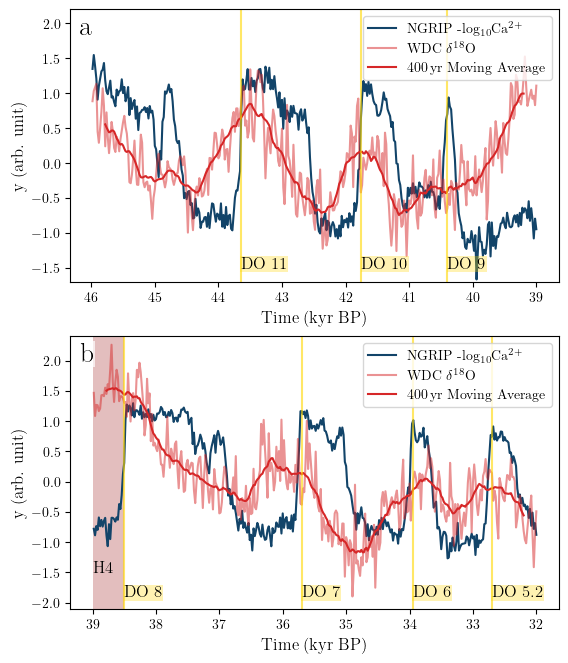

In [37]:
fig, ax = plt.subplots(2, 1, figsize=set_size(width, fraction=1, subplots=(2, 1)))

dT = 0.02
t = np.arange(-67.73, -10.4, dT)
t_ = [x for x in t]
plot_time = np.arange(39, 46, dT)

ax[0].plot(plot_time, normalize(data_cut(cal_,-46,-39)[1][::-1]), color = colors['cal'], label = "NGRIP -log$_{10}$Ca$^{2+}$")
ax[0].plot(plot_time, normalize(data_cut(wd_,-46,-39)[1][::-1]), color = colors['wdc'], alpha = 0.5, label = "WDC $\delta^{18}$O")

ax[0].plot(plot_time[10:-10], (normalize(data_cut(wd_,-46,-39)[1][::-1]) - 
                             subtract_moving(normalize(data_cut(wd_,-46,-39)[1][::-1]), 20, 'avg'))[10:-10],
        color = colors['wdc'], label = r'400\,yr Moving Average')

ax[0].legend(loc = 1)
ax[0].set_ylim(-1.7, 2.2)
ax[0].invert_xaxis()

ax[0].set_xlabel('Time (kyr BP)')
ax[0].set_ylabel('y (arb. unit)')

dT = 0.02
t = np.arange(-67.73, -10.4, dT)
t_ = [x for x in t]
plot_time = np.arange(32, 39, dT)

plt.plot(plot_time, normalize(data_cut(cal_,-39,-32)[1][::-1]), color = colors['cal'], label = "NGRIP -log$_{10}$Ca$^{2+}$")
plt.plot(plot_time, normalize(data_cut(wd_,-39,-32)[1][::-1]), color = colors['wdc'], alpha = 0.5, label = "WDC $\delta^{18}$O")

plt.plot(plot_time[10:-10], (normalize(data_cut(wd_,-39,-32)[1][::-1]) - 
                             subtract_moving(normalize(data_cut(wd_,-39,-32)[1][::-1]), 20, 'avg'))[10:-10],
        color = colors['wdc'], label = r'400\,yr Moving Average')

plt.legend(loc = 1)
plt.gca().invert_xaxis()

plt.xlabel('Time (kyr BP)')
plt.ylabel('y (arb. unit)')

dos = [32.7, 33.95, 35.7, 38.5, 40.4, 41.75, 43.65]
dos = [-i for i in dos]
do_name = [5.2, 6, 7, 8, 9, 10, 11]
do_posi = [0, 0, 0, 0, 0, 0, 0]
do_posi = [-i for i in do_posi]
for i in range(len(dos)):
    if i < 4:
        ax[1].axvline(x=-dos[i], c="gold", alpha = 0.6)
        ax[1].text(-dos[i]-do_posi[i],-1.9,'DO ' + str(do_name[i]), bbox=dict(facecolor='gold', alpha=0.3, edgecolor = 'none', pad = 0.5))
    else:
        ax[0].axvline(x=-dos[i], c="gold", alpha = 0.6)
        ax[0].text(-dos[i]-do_posi[i],-1.5,'DO ' + str(do_name[i]), bbox=dict(facecolor='gold', alpha=0.3, edgecolor = 'none', pad = 0.5))
        
hainrich_left = 38.5
hainricht_right = 39

ax[1].fill_between([38.5, 39], [-3,-3], color = "brown", edgecolor = 'none', alpha = 0.3)
ax[1].fill_between([38.5, 39], [3,3], color = "brown", edgecolor = 'none', alpha = 0.3)
ax[1].text(39, -1.5, 'H4')

ax[1].set_ylim(-2.1, 2.4)

abstand_prozent = 0.02
ax_text = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
for i, ax in enumerate((ax[0], ax[1])):
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    x_abstand = (xlim[1] - xlim[0]) * abstand_prozent
    y_abstand = (ylim[1] - ylim[0]) * abstand_prozent
    ax.text(xlim[0] + x_abstand, ylim[1] - y_abstand, ax_text[i], va='top', ha='left', size = 20, bbox=dict(facecolor='white', alpha=0.7, edgecolor = 'none', pad = 0.5))

fig.savefig('C:/Users/morit/Documents/Masterarbeit/output_M/data_zoom.jpg', format='jpg', dpi=600, bbox_inches='tight')

plt.show()